# Trabajo Final Visión por Computadora II - CEIA - UBA
## Análisis Exploratorio de Datos (EDA)

**Dataset seleccionado**: Chest CT-Scan images Dataset (Kaggle).

El objetivo con respecto a este dataset es la detección de nódulos pulmonares en tomografías de tórax

In [1]:
# ============================================================================
# IMPORTACIONES DE LIBRERÍAS
# ============================================================================

# Librerías estándar
import os
import hashlib
import random
from pathlib import Path
from collections import defaultdict

# Procesamiento de imágenes
from PIL import Image
import cv2
import imagehash

# Análisis de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Todas las librerías importadas correctamente")


✅ Todas las librerías importadas correctamente


## 1. Balanceo de clases

In [2]:
# Configuración inicial
data_dir = Path("Data")

CONTEO DE IMÁGENES POR CLASE

TRAIN:
--------------------------------------------------------------------------------
  normal                                            :  148 imágenes
  adenocarcinoma_left                               :  195 imágenes
  large.cell.carcinoma_left                         :  115 imágenes
  squamous.cell.carcinoma_left                      :  155 imágenes
  TOTAL                                             :  613 imágenes

VALID:
--------------------------------------------------------------------------------
  normal                                            :   13 imágenes
  adenocarcinoma_left                               :   23 imágenes
  large.cell.carcinoma_left                         :   21 imágenes
  squamous.cell.carcinoma_left                      :   15 imágenes
  TOTAL                                             :   72 imágenes

TEST:
--------------------------------------------------------------------------------
  normal                 

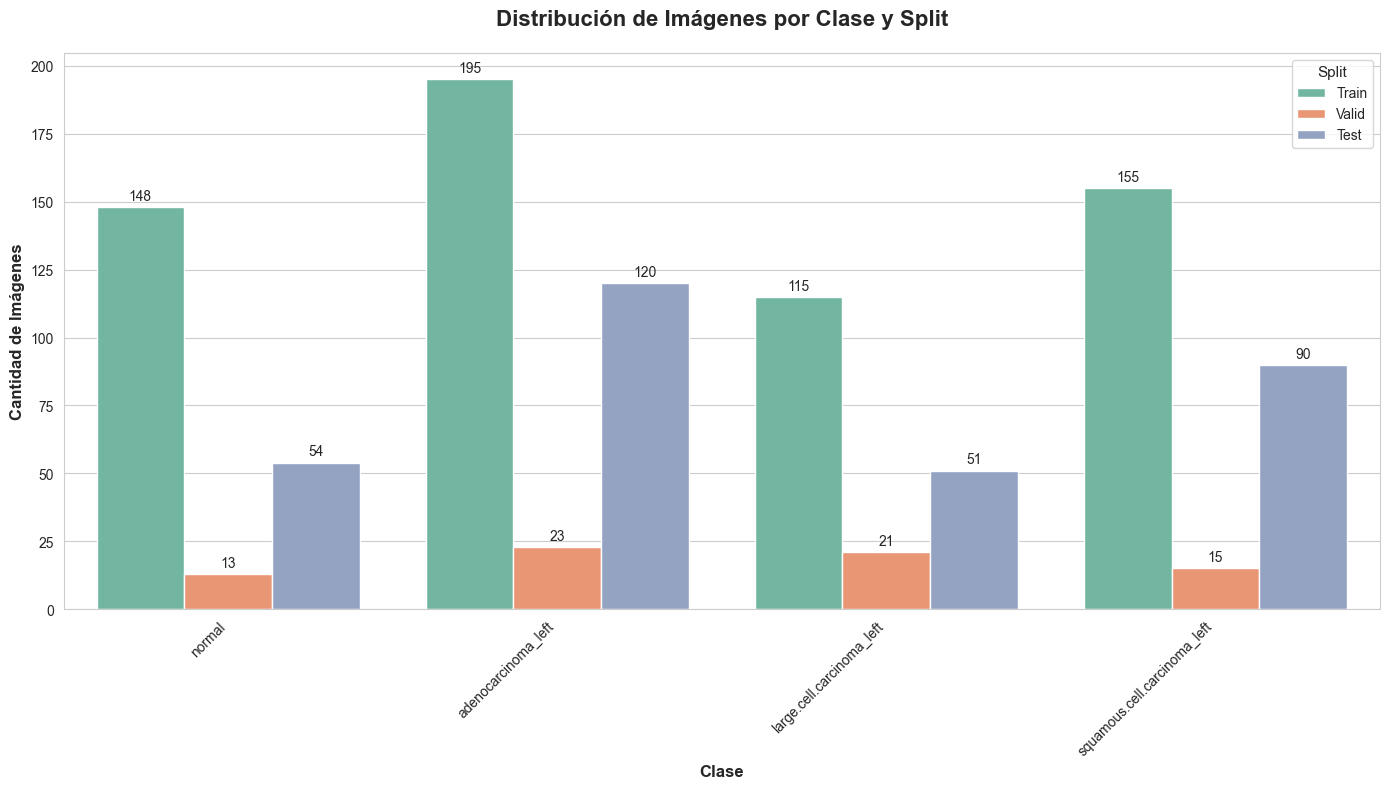

<Figure size 1400x800 with 0 Axes>

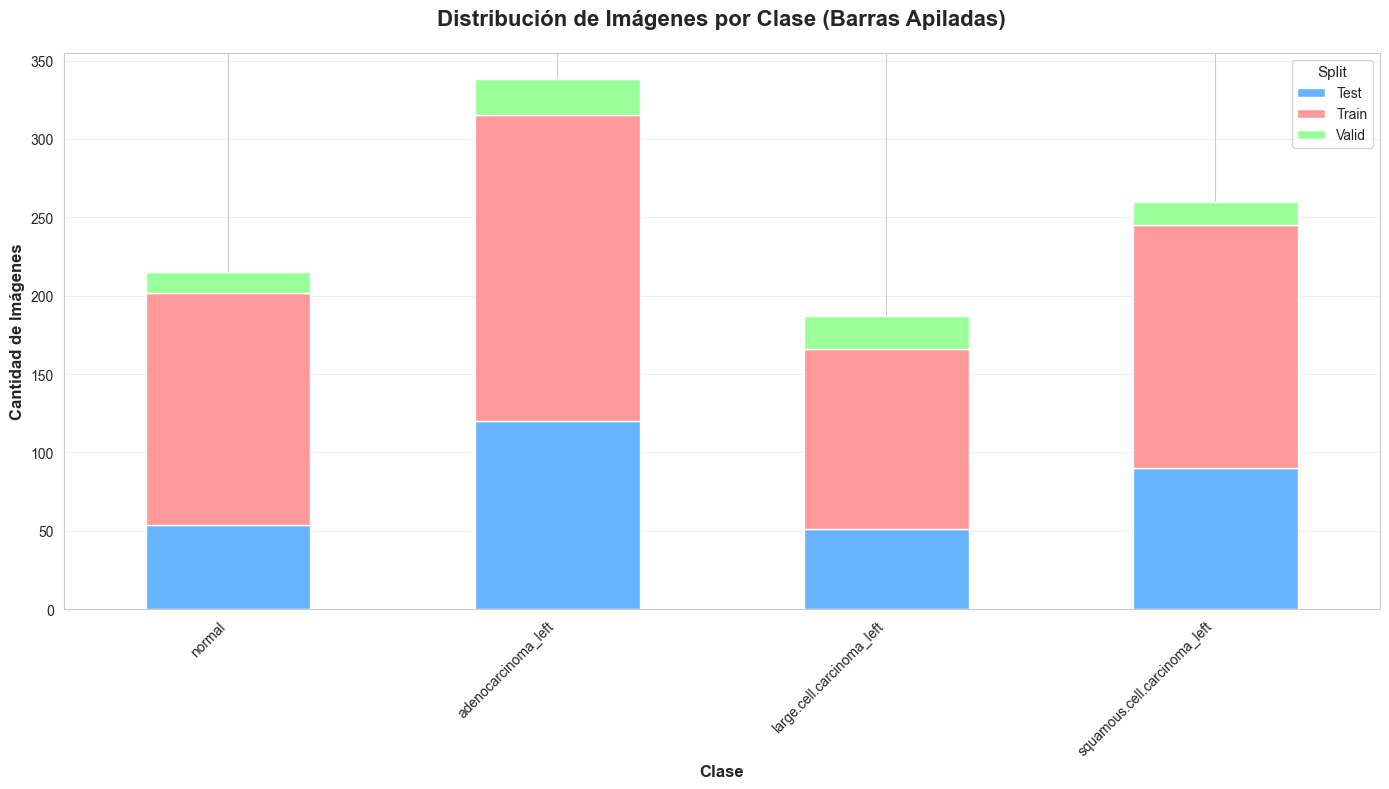

In [4]:
# Diccionario para almacenar conteos
counts = defaultdict(lambda: defaultdict(int))

# Extensiones de imagen válidas
image_extensions = {'.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'}

# Función para normalizar nombres de clases
def normalize_class_name(class_name):
    """Normaliza el nombre de la clase según el patrón: normal, adenocarcinoma_left, large.cell.carcinoma_left, squamous.cell.carcinoma_left"""
    if class_name == 'normal':
        return 'normal'
    elif class_name.startswith('adenocarcinoma'):
        return 'adenocarcinoma_left'
    elif class_name.startswith('large.cell.carcinoma'):
        return 'large.cell.carcinoma_left'
    elif class_name.startswith('squamous.cell.carcinoma'):
        return 'squamous.cell.carcinoma_left'
    else:
        return class_name

# Recorrer train, valid y test
for split in ['train', 'valid', 'test']:
    split_path = data_dir / split
    if split_path.exists():
        # Recorrer cada subcarpeta (clase)
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                # Contar imágenes en la carpeta
                image_count = sum(1 for file in class_folder.iterdir() 
                                if file.is_file() and file.suffix in image_extensions)
                # Normalizar nombre de clase
                normalized_class = normalize_class_name(class_name)
                counts[split][normalized_class] += image_count

# Mostrar resultados
print("=" * 80)
print("CONTEO DE IMÁGENES POR CLASE")
print("=" * 80)

# Mostrar por split
for split in ['train', 'valid', 'test']:
    if split in counts:
        print(f"\n{split.upper()}:")
        print("-" * 80)
        total_split = 0
        for class_name in ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']:
            count = counts[split].get(class_name, 0)
            print(f"  {class_name:50s}: {count:4d} imágenes")
            total_split += count
        print(f"  {'TOTAL':50s}: {total_split:4d} imágenes")

# Resumen por clase (sumando todos los splits)
print("\n" + "=" * 80)
print("RESUMEN TOTAL POR CLASE (train + valid + test)")
print("=" * 80)

class_totals = defaultdict(int)
for split in ['train', 'valid', 'test']:
    if split in counts:
        for class_name, count in counts[split].items():
            class_totals[class_name] += count

for class_name in ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']:
    total = class_totals.get(class_name, 0)
    print(f"  {class_name:50s}: {total:4d} imágenes")

print(f"\n{'TOTAL GENERAL':50s}: {sum(class_totals.values()):4d} imágenes")
print("=" * 80)

# Crear DataFrame para visualización
data_list = []
for split in ['train', 'valid', 'test']:
    if split in counts:
        for class_name in ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']:
            count = counts[split].get(class_name, 0)
            data_list.append({
                'Split': split.capitalize(),
                'Clase': class_name,
                'Cantidad': count
            })

df = pd.DataFrame(data_list)

# Configurar estilo de seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Crear gráfico de barras agrupadas
ax = sns.barplot(data=df, x='Clase', y='Cantidad', hue='Split', palette='Set2')
plt.title('Distribución de Imágenes por Clase y Split', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Clase', fontsize=12, fontweight='bold')
plt.ylabel('Cantidad de Imágenes', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Split', title_fontsize=11, fontsize=10)

# Agregar valores en las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

# Crear gráfico de barras apiladas
plt.figure(figsize=(14, 8))
df_pivot = df.pivot(index='Clase', columns='Split', values='Cantidad')
df_pivot = df_pivot.reindex(['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left'])

ax2 = df_pivot.plot(kind='bar', stacked=True, color=['#66b3ff', '#ff9999', '#99ff99'], figsize=(14, 8))
plt.title('Distribución de Imágenes por Clase (Barras Apiladas)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Clase', fontsize=12, fontweight='bold')
plt.ylabel('Cantidad de Imágenes', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Split', title_fontsize=11, fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Comentarios sobre el Balanceo de Clases

**Hallazgos principales:**

1. **Balanceo entre clases**: 
   - Las clases están relativamente balanceadas en el conjunto de entrenamiento
   - La clase `adenocarcinoma_left` tiene la mayor cantidad de imágenes (338 total)
   - La clase `large.cell.carcinoma_left` tiene la menor cantidad (187 total)
   - La diferencia entre la clase mayoritaria y minoritaria es de aproximadamente 1.8x

2. **Implicaciones para el modelo**:
   - El desbalance es moderado, por lo que puede ser manejado con técnicas de balanceo de clases (pesos de clase, oversampling, etc.)
   - Una opción usar pesos de clase inversamente proporcionales a la frecuencia para el entrenamiento
   - Se deberán considerar técnicas de data augmentation para las clases minoritarias


## 2. Visualización de Imágenes


Normal: 6 imágenes encontradas
Adenocarcinoma: 6 imágenes encontradas
Large Cell Carcinoma: 6 imágenes encontradas
Squamous Cell Carcinoma: 6 imágenes encontradas


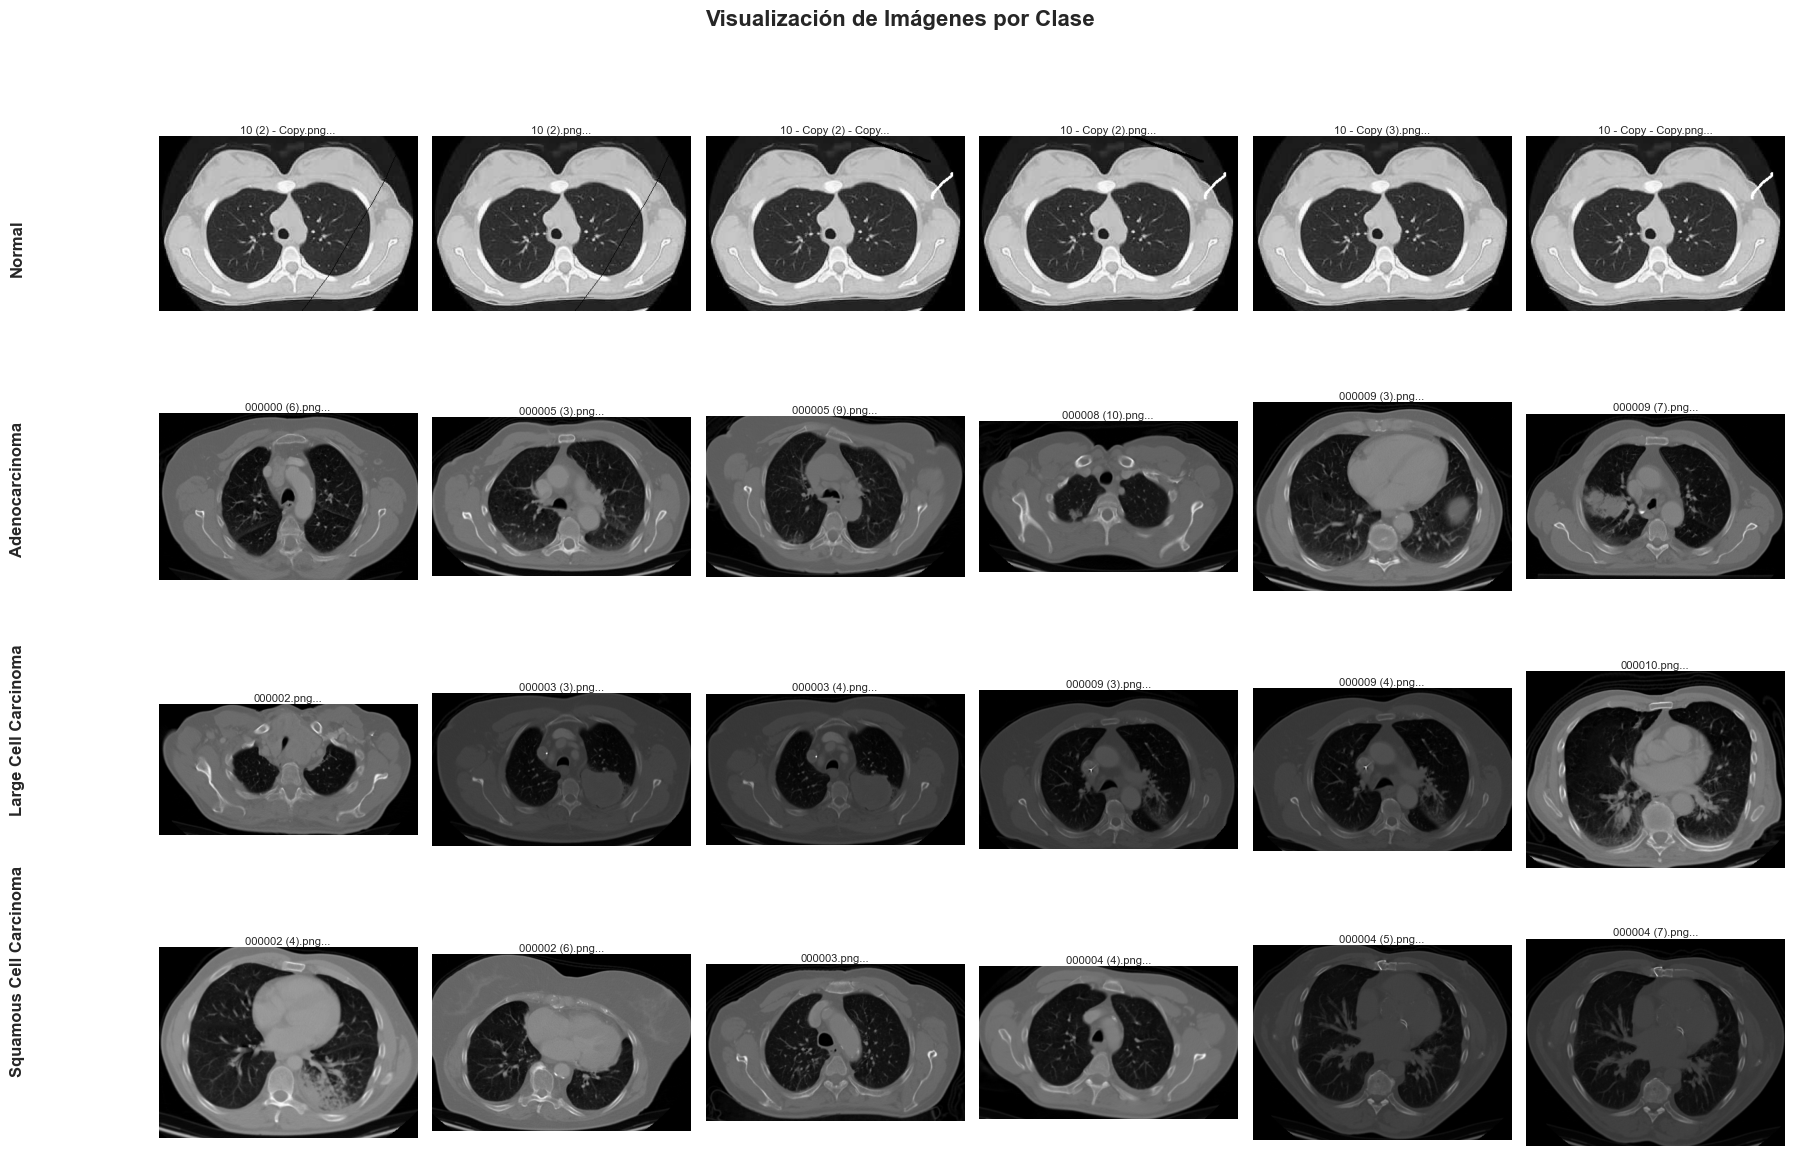

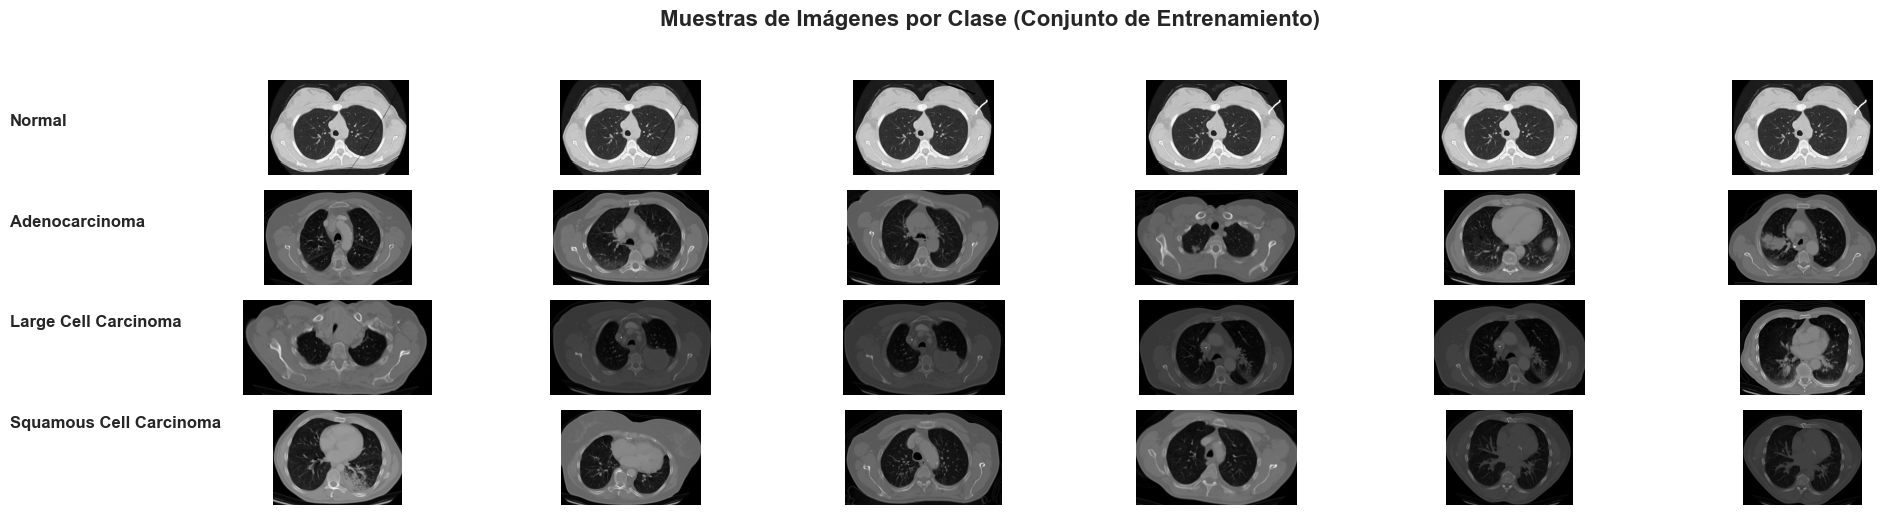

In [5]:
# Función para obtener imágenes de una clase
def get_class_images(class_name, split='train', num_images=6):
    """Obtiene un número específico de imágenes de una clase"""
    split_path = data_dir / split
    images = []
    
    # Buscar en todas las carpetas que coincidan con la clase
    for class_folder in split_path.iterdir():
        if class_folder.is_dir():
            normalized = normalize_class_name(class_folder.name)
            if normalized == class_name:
                # Recopilar todas las imágenes de esta carpeta
                for image_file in class_folder.iterdir():
                    if image_file.is_file() and image_file.suffix in image_extensions:
                        images.append(image_file)
                        if len(images) >= num_images:
                            break
                if len(images) >= num_images:
                    break
    
    return images[:num_images]

# Configurar clases y número de imágenes por clase
classes = ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']
class_labels = {
    'normal': 'Normal',
    'adenocarcinoma_left': 'Adenocarcinoma',
    'large.cell.carcinoma_left': 'Large Cell Carcinoma',
    'squamous.cell.carcinoma_left': 'Squamous Cell Carcinoma'
}
num_images_per_class = 6
split_to_use = 'train'  # Usar imágenes del conjunto de entrenamiento

# Recopilar imágenes de cada clase
class_image_dict = {}
for class_name in classes:
    images = get_class_images(class_name, split=split_to_use, num_images=num_images_per_class)
    class_image_dict[class_name] = images
    print(f"{class_labels[class_name]}: {len(images)} imágenes encontradas")

# Crear visualización con subplots
fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(18, 12))
fig.suptitle('Visualización de Imágenes por Clase', fontsize=16, fontweight='bold', y=0.995)

# Si solo hay una fila, asegurar que axes sea 2D
if len(classes) == 1:
    axes = axes.reshape(1, -1)
elif num_images_per_class == 1:
    axes = axes.reshape(-1, 1)

# Mostrar imágenes para cada clase
for row, class_name in enumerate(classes):
    images = class_image_dict[class_name]
    
    for col in range(num_images_per_class):
        ax = axes[row, col]
        ax.axis('off')
        
        if col < len(images):
            try:
                img = Image.open(images[col])
                ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
                ax.set_title(f'{images[col].name[:20]}...', fontsize=8, pad=2)
            except Exception as e:
                ax.text(0.5, 0.5, f'Error\ncargando\nimagen', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=8)
        else:
            ax.text(0.5, 0.5, 'No disponible', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=8)
    
    # Agregar etiqueta de clase alineada con el centro de la fila
    # Usar el primer subplot de la fila como referencia para la posición vertical
    first_ax = axes[row, 0]
    # Convertir coordenadas del subplot a coordenadas de la figura
    bbox = first_ax.get_position()
    # Obtener el centro vertical de la fila
    y_center = bbox.y0 + bbox.height / 2
    # Agregar texto en el lado izquierdo, centrado verticalmente con la fila
    fig.text(0.01, y_center, class_labels[class_name], 
            fontsize=12, fontweight='bold', rotation=90, 
            ha='center', va='center', transform=fig.transFigure)

plt.tight_layout(rect=[0.08, 0, 1, 0.98])
plt.show()

# Visualización alternativa: una fila por clase con mejor espaciado
fig2, axes2 = plt.subplots(len(classes), num_images_per_class, figsize=(20, 5))
fig2.suptitle('Muestras de Imágenes por Clase (Conjunto de Entrenamiento)', 
             fontsize=16, fontweight='bold', y=1.02)

if len(classes) == 1:
    axes2 = axes2.reshape(1, -1)
elif num_images_per_class == 1:
    axes2 = axes2.reshape(-1, 1)

for row, class_name in enumerate(classes):
    images = class_image_dict[class_name]
    
    for col in range(num_images_per_class):
        ax = axes2[row, col]
        ax.axis('off')
        
        if col < len(images):
            try:
                img = Image.open(images[col])
                ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
            except Exception as e:
                ax.text(0.5, 0.5, 'Error', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=10)
        else:
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=10)
    
    # Título de la fila (clase) - mejor alineado usando coordenadas de figura
    first_ax = axes2[row, 0]
    bbox = first_ax.get_position()
    y_center = bbox.y0 + bbox.height / 2
    fig2.text(0.01, y_center, class_labels[class_name], 
             fontsize=12, fontweight='bold', 
             ha='left', va='center', rotation=0, transform=fig2.transFigure)

plt.tight_layout(rect=[0.08, 0, 1, 0.98])
plt.show()


### Comentarios sobre la Visualización de Imágenes

**Observaciones visuales:**

1. **Variabilidad visual**: Las imágenes muestran variabilidad significativa en términos de:
   - Orientación y posición de las estructuras anatómicas
   - Intensidad y contraste
   - Presencia de marcas

2. **Características por clase**:
   - Las imágenes de cada clase presentan patrones visuales distintivos
   - Es importante notar que las imágenes CT pueden tener diferentes ventanas de visualización (lung window, mediastinal window, etc.)

3. **Implicancias para el modelo**:
   - Una opción a evaluar es normalización de intensidades antes del entrenamiento
   - Evaluar normalización de tamaños (ej. cuadrado) antes del entrenamiento
   - Evaluar data augmentation en cuanto a brillo, contraste y ruido
   - Evaluar data augmentation espacial (rotación, flip horizontal, traslación, escala)
   - Evitar augmentations agresivos que puedan alterar la información médica

## 3. Tamaño de imágenes

Analizando tamaños de imágenes...

ESTADÍSTICAS DE TAMAÑOS DE IMÁGENES

ESTADÍSTICAS GENERALES:
--------------------------------------------------------------------------------
Total de imágenes analizadas: 1000

Ancho (Width):
  Mínimo: 168 px
  Máximo: 1200 px
  Promedio: 447.00 px
  Mediana: 419.00 px

Alto (Height):
  Mínimo: 110 px
  Máximo: 874 px
  Promedio: 317.78 px
  Mediana: 296.00 px

ESTADÍSTICAS POR SPLIT

TRAIN:
  Cantidad: 613 imágenes
  Ancho: 168 - 1200 px (promedio: 435.8 px)
  Alto: 110 - 874 px (promedio: 303.3 px)

VALID:
  Cantidad: 72 imágenes
  Ancho: 315 - 940 px (promedio: 437.8 px)
  Alto: 181 - 627 px (promedio: 299.5 px)

TEST:
  Cantidad: 315 imágenes
  Ancho: 360 - 940 px (promedio: 470.8 px)
  Alto: 232 - 700 px (promedio: 350.1 px)

ESTADÍSTICAS POR CLASE

normal:
  Cantidad: 215 imágenes
  Ancho: 224 - 940 px (promedio: 593.6 px)
  Alto: 210 - 700 px (promedio: 445.1 px)

adenocarcinoma_left:
  Cantidad: 338 imágenes
  Ancho: 172 - 1200 px (promedio: 

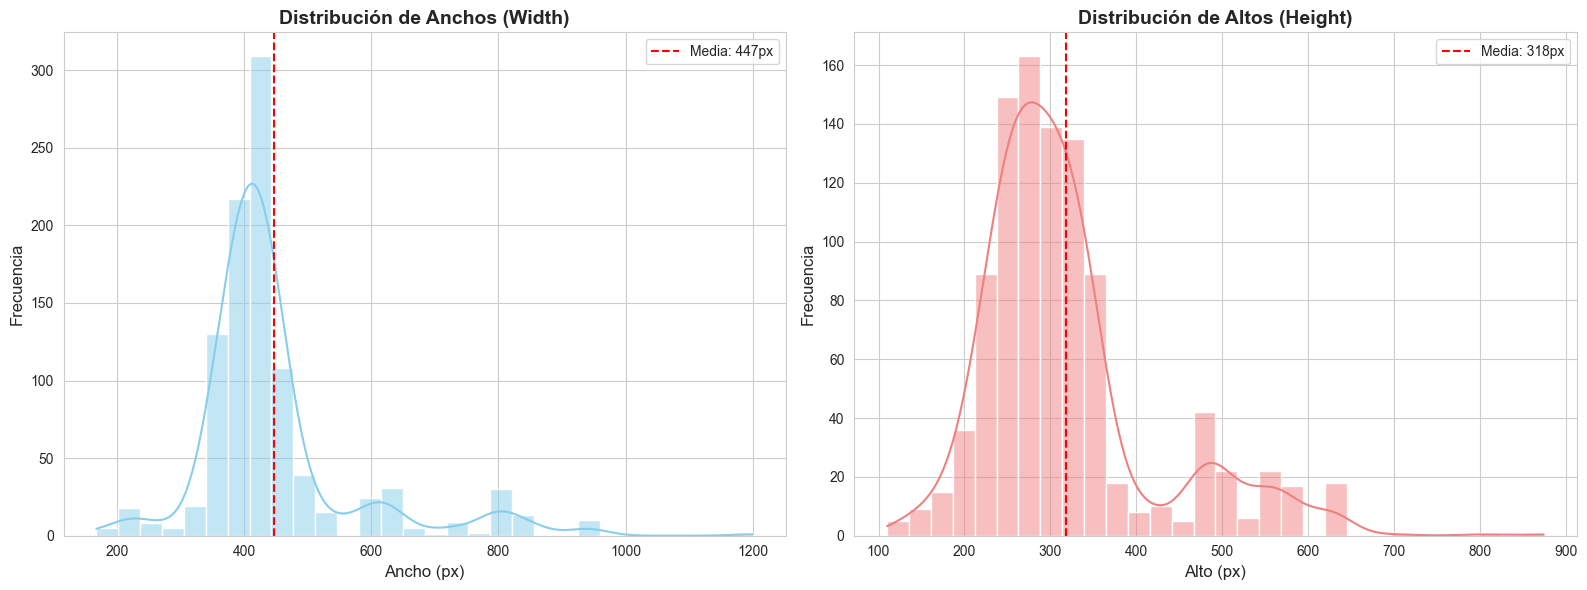

C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\665478080.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sizes, x='Clase', y='Ancho', ax=axes[0], palette='Set3')
C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\665478080.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sizes, x='Clase', y='Alto', ax=axes[1], palette='Set3')


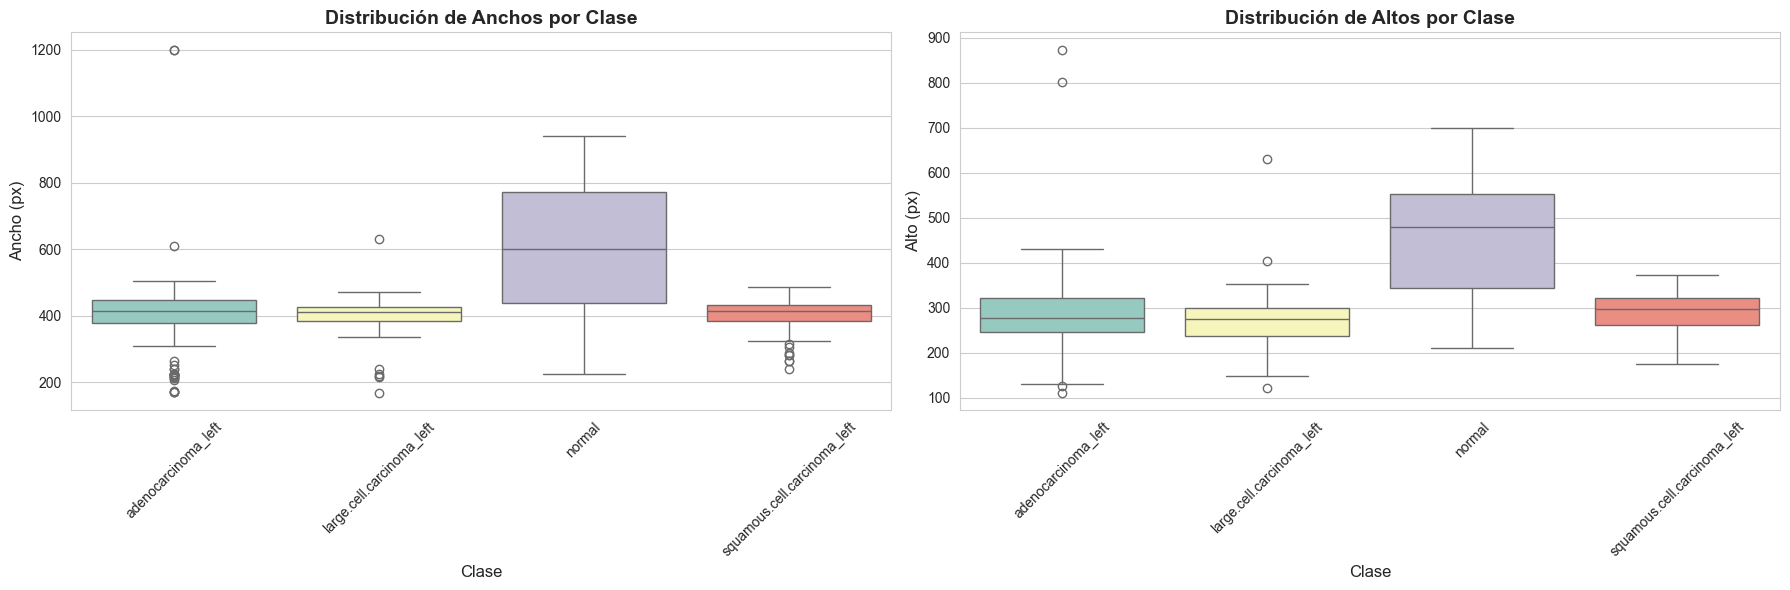

In [6]:
# Lista para almacenar información de las imágenes
image_data = []

# Recorrer train, valid y test
print("Analizando tamaños de imágenes...")
for split in ['train', 'valid', 'test']:
    split_path = data_dir / split
    if split_path.exists():
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                normalized_class = normalize_class_name(class_name)
                
                # Recorrer todas las imágenes en la carpeta
                for image_file in class_folder.iterdir():
                    if image_file.is_file() and image_file.suffix in image_extensions:
                        try:
                            with Image.open(image_file) as img:
                                width, height = img.size
                                image_data.append({
                                    'Split': split,
                                    'Clase': normalized_class,
                                    'Ancho': width,
                                    'Alto': height,
                                    'Total_Pixeles': width * height,
                                    'Archivo': image_file.name
                                })
                        except Exception as e:
                            print(f"Error al leer {image_file}: {e}")

# Crear DataFrame
df_sizes = pd.DataFrame(image_data)

# Mostrar estadísticas generales
print("\n" + "=" * 80)
print("ESTADÍSTICAS DE TAMAÑOS DE IMÁGENES")
print("=" * 80)

print("\nESTADÍSTICAS GENERALES:")
print("-" * 80)
print(f"Total de imágenes analizadas: {len(df_sizes)}")
print(f"\nAncho (Width):")
print(f"  Mínimo: {df_sizes['Ancho'].min()} px")
print(f"  Máximo: {df_sizes['Ancho'].max()} px")
print(f"  Promedio: {df_sizes['Ancho'].mean():.2f} px")
print(f"  Mediana: {df_sizes['Ancho'].median():.2f} px")
print(f"\nAlto (Height):")
print(f"  Mínimo: {df_sizes['Alto'].min()} px")
print(f"  Máximo: {df_sizes['Alto'].max()} px")
print(f"  Promedio: {df_sizes['Alto'].mean():.2f} px")
print(f"  Mediana: {df_sizes['Alto'].median():.2f} px")


# Estadísticas por split
print("\n" + "=" * 80)
print("ESTADÍSTICAS POR SPLIT")
print("=" * 80)
for split in ['train', 'valid', 'test']:
    df_split = df_sizes[df_sizes['Split'] == split]
    if len(df_split) > 0:
        print(f"\n{split.upper()}:")
        print(f"  Cantidad: {len(df_split)} imágenes")
        print(f"  Ancho: {df_split['Ancho'].min()} - {df_split['Ancho'].max()} px (promedio: {df_split['Ancho'].mean():.1f} px)")
        print(f"  Alto: {df_split['Alto'].min()} - {df_split['Alto'].max()} px (promedio: {df_split['Alto'].mean():.1f} px)")

# Estadísticas por clase
print("\n" + "=" * 80)
print("ESTADÍSTICAS POR CLASE")
print("=" * 80)
for clase in ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']:
    df_clase = df_sizes[df_sizes['Clase'] == clase]
    if len(df_clase) > 0:
        print(f"\n{clase}:")
        print(f"  Cantidad: {len(df_clase)} imágenes")
        print(f"  Ancho: {df_clase['Ancho'].min()} - {df_clase['Ancho'].max()} px (promedio: {df_clase['Ancho'].mean():.1f} px)")
        print(f"  Alto: {df_clase['Alto'].min()} - {df_clase['Alto'].max()} px (promedio: {df_clase['Alto'].mean():.1f} px)")

# Tamaños únicos
print("\n" + "=" * 80)
print("TAMAÑOS ÚNICOS ENCONTRADOS")
print("=" * 80)
unique_sizes = df_sizes.groupby(['Ancho', 'Alto']).size().reset_index(name='Cantidad')
unique_sizes = unique_sizes.sort_values('Cantidad', ascending=False)
print(f"\nTotal de tamaños únicos: {len(unique_sizes)}")
print("\nTop 10 tamaños más comunes:")
print(unique_sizes.head(10).to_string(index=False))

# Visualizaciones
sns.set_style("whitegrid")

# 1. Distribución de anchos y altos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=df_sizes, x='Ancho', bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Anchos (Width)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Ancho (px)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].axvline(df_sizes['Ancho'].mean(), color='red', linestyle='--', label=f'Media: {df_sizes["Ancho"].mean():.0f}px')
axes[0].legend()

sns.histplot(data=df_sizes, x='Alto', bins=30, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Distribución de Altos (Height)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Alto (px)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].axvline(df_sizes['Alto'].mean(), color='red', linestyle='--', label=f'Media: {df_sizes["Alto"].mean():.0f}px')
axes[1].legend()

plt.tight_layout()
plt.show()



# 4. Box plots por clase
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=df_sizes, x='Clase', y='Ancho', ax=axes[0], palette='Set3')
axes[0].set_title('Distribución de Anchos por Clase', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase', fontsize=12)
axes[0].set_ylabel('Ancho (px)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df_sizes, x='Clase', y='Alto', ax=axes[1], palette='Set3')
axes[1].set_title('Distribución de Altos por Clase', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Clase', fontsize=12)
axes[1].set_ylabel('Alto (px)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



### Comentarios sobre los Tamaños de Imágenes

**Hallazgos principales:**

1. **Variabilidad de tamaños**: 
   - Los tamaños varían significativamente: desde 168x110 px hasta 1200x874 px
   - El tamaño promedio es de aproximadamente 447x318 px
   - Esta variabilidad requiere estrategias de preprocesamiento consistentes

2. **Diferencias por clase**:
   - La clase `normal` tiene imágenes más grandes en promedio (593.6x445.1 px)
   - Las clases de carcinoma tienen tamaños más pequeños y consistentes
   - Esto podría indicar diferentes protocolos de adquisición o procesamiento

3. **Implicancias para el modelo**:
   - **Resize uniforme**: Redimensionar todas las imágenes a un tamaño fijo (ej: 512x512 o 256x256)
   - **Aspect ratio**: Considerar mantener el aspect ratio original con padding o usar center crop
   - **Validación**: Asegurarse de que el resize no recorte estructuras anatómicas importantes (pulmones)
   - **Letterboxing**: Alternativa al resize directo para mantener proporciones


## 4. Análisis de Histogramas de Colores y Separabilidad de Clases


In [ ]:
# Función para extraer histograma de color de una imagen
def extract_color_histogram(image_path, bins=256):
    """Extrae histograma RGB de una imagen"""
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        
        # Convertir BGR a RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Calcular histogramas para cada canal
        hist_r = cv2.calcHist([img_rgb], [0], None, [bins], [0, 256])
        hist_g = cv2.calcHist([img_rgb], [1], None, [bins], [0, 256])
        hist_b = cv2.calcHist([img_rgb], [2], None, [bins], [0, 256])
        
        # Normalizar histogramas
        hist_r = hist_r.flatten() / (img_rgb.shape[0] * img_rgb.shape[1])
        hist_g = hist_g.flatten() / (img_rgb.shape[0] * img_rgb.shape[1])
        hist_b = hist_b.flatten() / (img_rgb.shape[0] * img_rgb.shape[1])
        
        # Concatenar histogramas
        hist_combined = np.concatenate([hist_r, hist_g, hist_b])
        
        return hist_combined
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

# Función para extraer características estadísticas del histograma
def extract_histogram_features(hist):
    """Extrae características estadísticas del histograma"""
    if hist is None:
        return None
    
    # Dividir en canales R, G, B
    bins = len(hist) // 3
    hist_r = hist[:bins]
    hist_g = hist[bins:2*bins]
    hist_b = hist[2*bins:]
    
    features = []
    for channel_hist in [hist_r, hist_g, hist_b]:
        # Estadísticas del histograma
        features.extend([
            np.mean(channel_hist),      # Media
            np.std(channel_hist),       # Desviación estándar
            np.median(channel_hist),    # Mediana
            np.percentile(channel_hist, 25),  # Q1
            np.percentile(channel_hist, 75),  # Q3
            np.max(channel_hist),      # Máximo
            np.argmax(channel_hist),    # Moda (índice del valor máximo)
            np.sum(channel_hist > np.mean(channel_hist)),  # Píxeles sobre la media
        ])
    
    return np.array(features)

# Recopilar datos de imágenes (usar solo train para análisis más rápido)
print("Extrayendo histogramas de colores de las imágenes...")
histogram_data = []
histogram_features = []
class_labels = []
image_paths = []

# Limitar a train para análisis más rápido (se puede cambiar a ['train', 'valid', 'test'] para todo)
for split in ['train']:
    split_path = data_dir / split
    if split_path.exists():
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                normalized_class = normalize_class_name(class_name)
                
                # Recorrer todas las imágenes en la carpeta
                for image_file in class_folder.iterdir():
                    if image_file.is_file() and image_file.suffix in image_extensions:
                        hist = extract_color_histogram(image_file)
                        if hist is not None:
                            histogram_data.append(hist)
                            features = extract_histogram_features(hist)
                            if features is not None:
                                histogram_features.append(features)
                                class_labels.append(normalized_class)
                                image_paths.append(str(image_file))

print(f"Procesadas {len(histogram_data)} imágenes")
print(f"Dimensiones del histograma: {len(histogram_data[0])}")
print(f"Dimensiones de características: {len(histogram_features[0])}")

# Convertir a arrays numpy
histogram_data = np.array(histogram_data)
histogram_features = np.array(histogram_features)
class_labels = np.array(class_labels)

print(f"\nClases encontradas: {np.unique(class_labels)}")
print(f"Cantidad por clase:")
for clase in np.unique(class_labels):
    print(f"  {clase}: {np.sum(class_labels == clase)}")


Extrayendo histogramas de colores de las imágenes...
Procesadas 613 imágenes
Dimensiones del histograma: 768
Dimensiones de características: 24

Clases encontradas: ['adenocarcinoma_left' 'large.cell.carcinoma_left' 'normal'
 'squamous.cell.carcinoma_left']
Cantidad por clase:
  adenocarcinoma_left: 195
  large.cell.carcinoma_left: 115
  normal: 148
  squamous.cell.carcinoma_left: 155


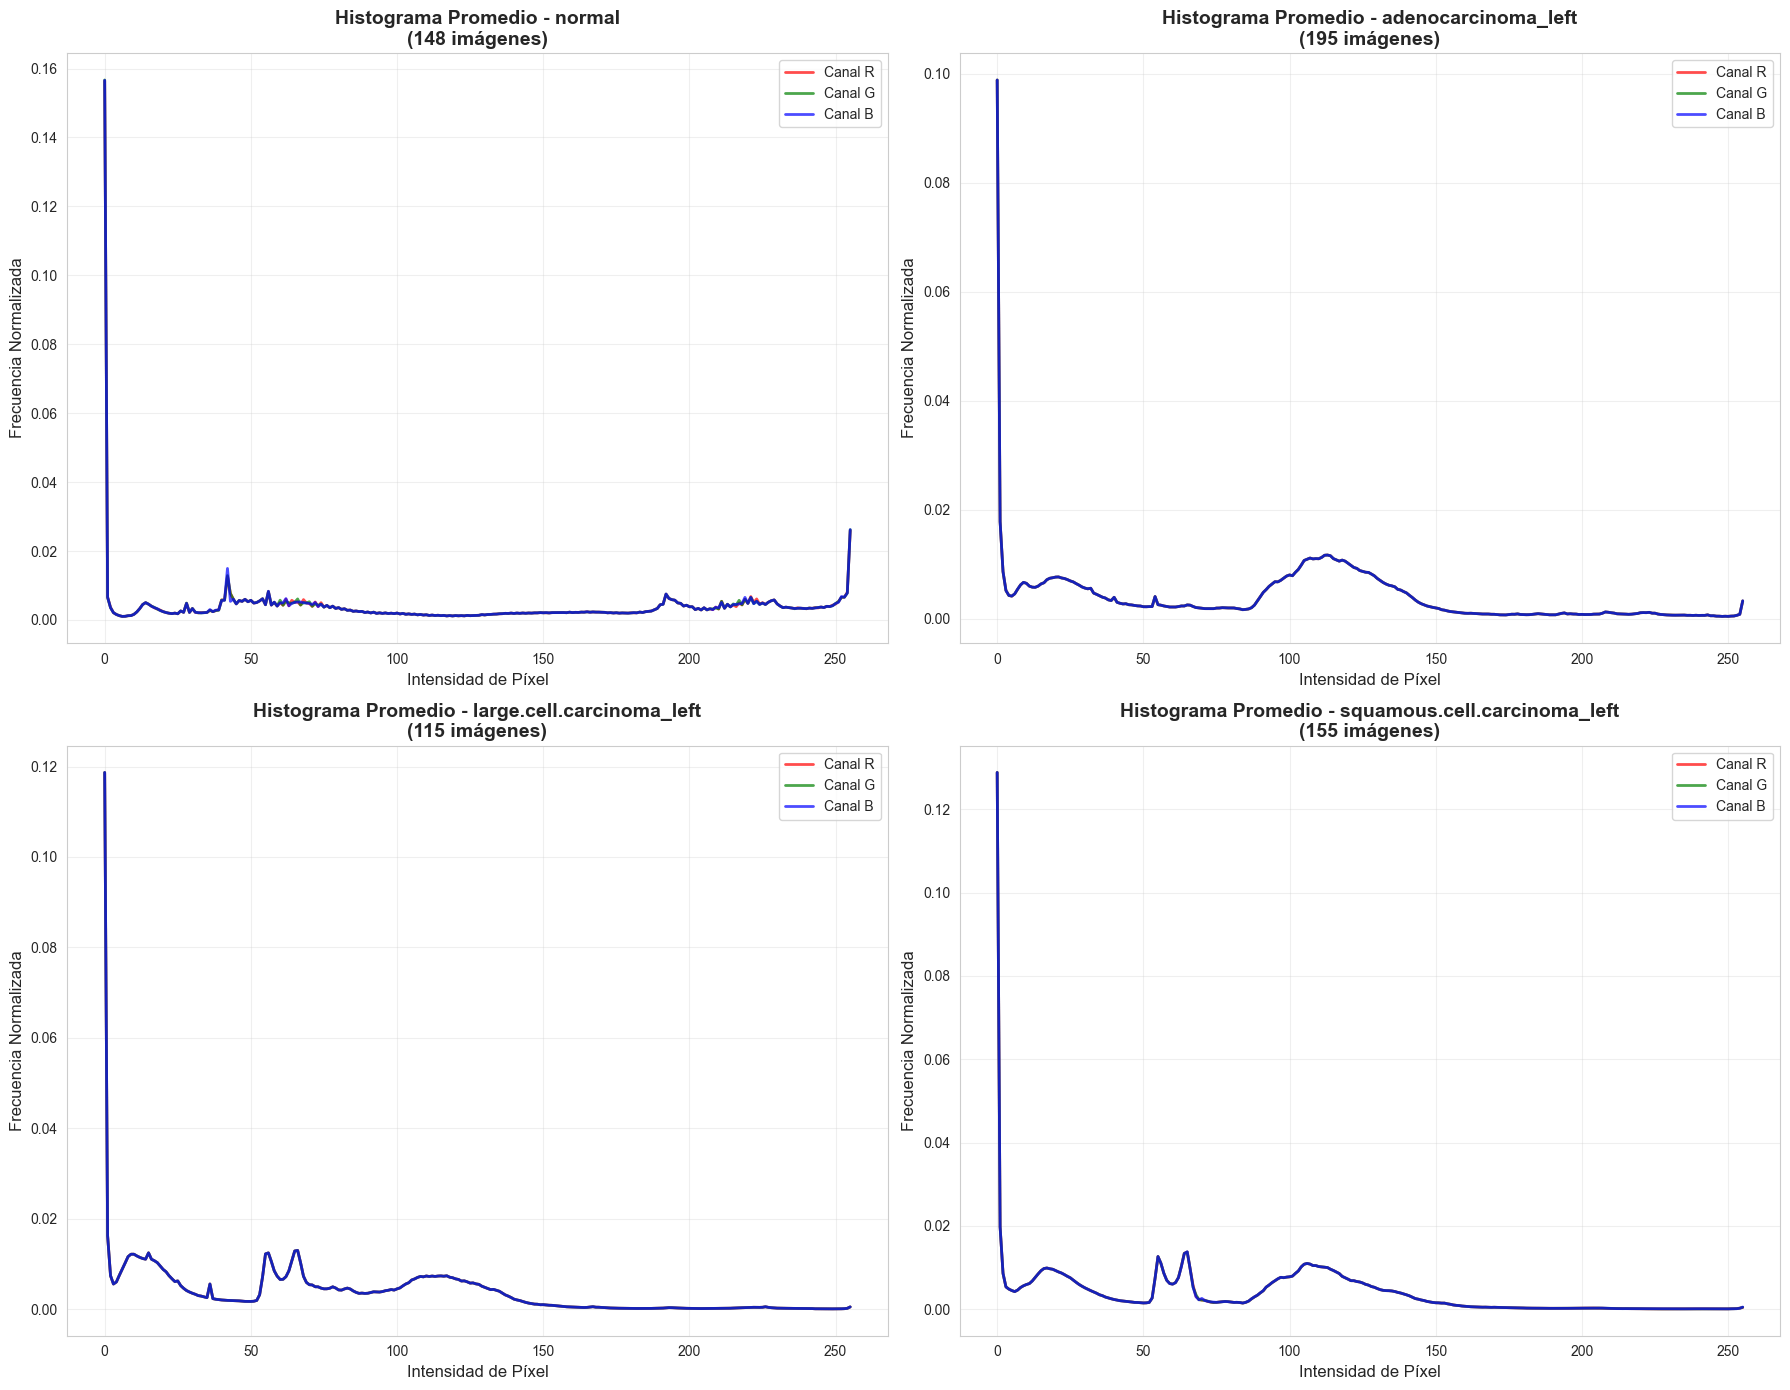

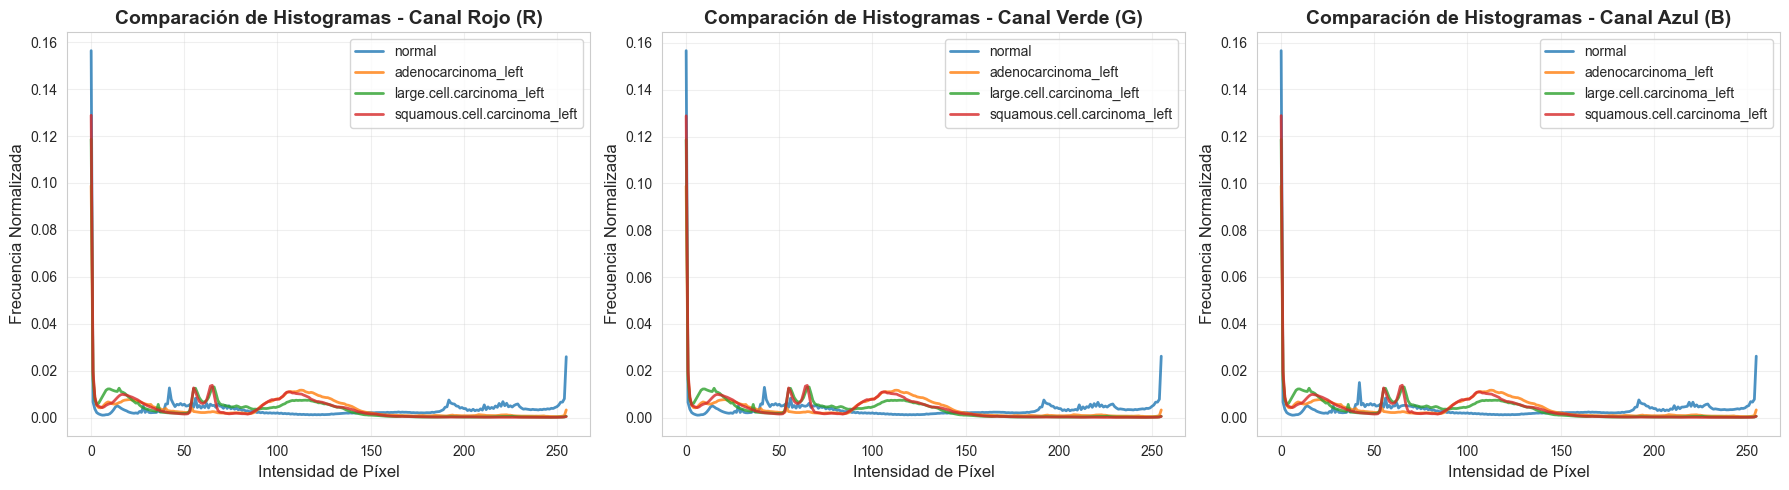

In [8]:
# Visualización de histogramas de colores por clase
sns.set_style("whitegrid")

# Verificar que las variables necesarias existan
if 'histogram_data' not in globals() or len(histogram_data) == 0:
    raise ValueError("Error: Primero ejecuta la celda anterior para extraer histogramas")

# Calcular histogramas promedio por clase
classes = ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']
colors = ['red', 'green', 'blue']
color_names = ['Rojo (R)', 'Verde (G)', 'Azul (B)']

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, clase in enumerate(classes):
    ax = axes[idx]
    class_mask = class_labels == clase
    if np.sum(class_mask) > 0:
        # Calcular histograma promedio para esta clase
        class_histograms = histogram_data[class_mask]
        avg_hist = np.mean(class_histograms, axis=0)
        
        bins = len(avg_hist) // 3
        hist_r = avg_hist[:bins]
        hist_g = avg_hist[bins:2*bins]
        hist_b = avg_hist[2*bins:]
        
        # Graficar histogramas de cada canal
        x = np.arange(bins)
        ax.plot(x, hist_r, color='red', alpha=0.7, label='Canal R', linewidth=2)
        ax.plot(x, hist_g, color='green', alpha=0.7, label='Canal G', linewidth=2)
        ax.plot(x, hist_b, color='blue', alpha=0.7, label='Canal B', linewidth=2)
        
        ax.set_title(f'Histograma Promedio - {clase}\n({np.sum(class_mask)} imágenes)', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Intensidad de Píxel', fontsize=12)
        ax.set_ylabel('Frecuencia Normalizada', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'No hay imágenes para {clase}', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'Histograma - {clase}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Comparación de histogramas superpuestos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for channel_idx, (channel_name, channel_color) in enumerate(zip(['Rojo (R)', 'Verde (G)', 'Azul (B)'], 
                                                                  ['red', 'green', 'blue'])):
    ax = axes[channel_idx]
    
    bins = len(histogram_data[0]) // 3
    start_idx = channel_idx * bins
    end_idx = (channel_idx + 1) * bins
    
    for clase in classes:
        class_mask = class_labels == clase
        if np.sum(class_mask) > 0:
            class_histograms = histogram_data[class_mask]
            avg_hist = np.mean(class_histograms[:, start_idx:end_idx], axis=0)
            x = np.arange(bins)
            ax.plot(x, avg_hist, label=clase, linewidth=2, alpha=0.8)
    
    ax.set_title(f'Comparación de Histogramas - Canal {channel_name}', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Intensidad de Píxel', fontsize=12)
    ax.set_ylabel('Frecuencia Normalizada', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


ANÁLISIS DE SEPARABILIDAD DE CLASES

Aplicando PCA para reducción inicial...
Número de características: 24, muestras: 613, usando 24 componentes PCA
Varianza explicada por los primeros 24 componentes PCA: 1.0000

Aplicando t-SNE...
t-SNE completado!


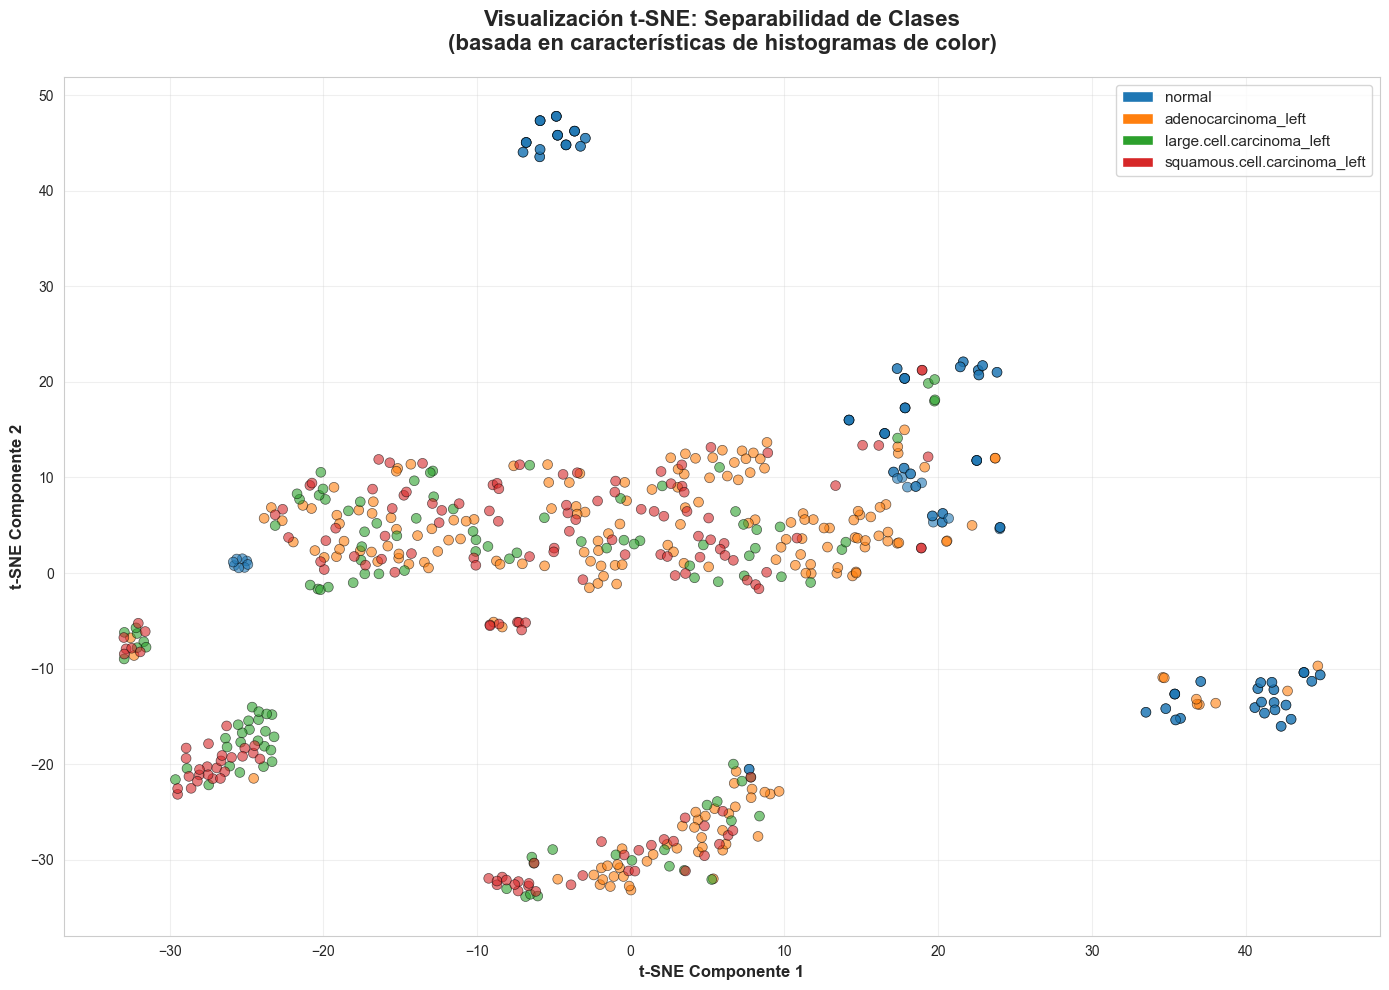

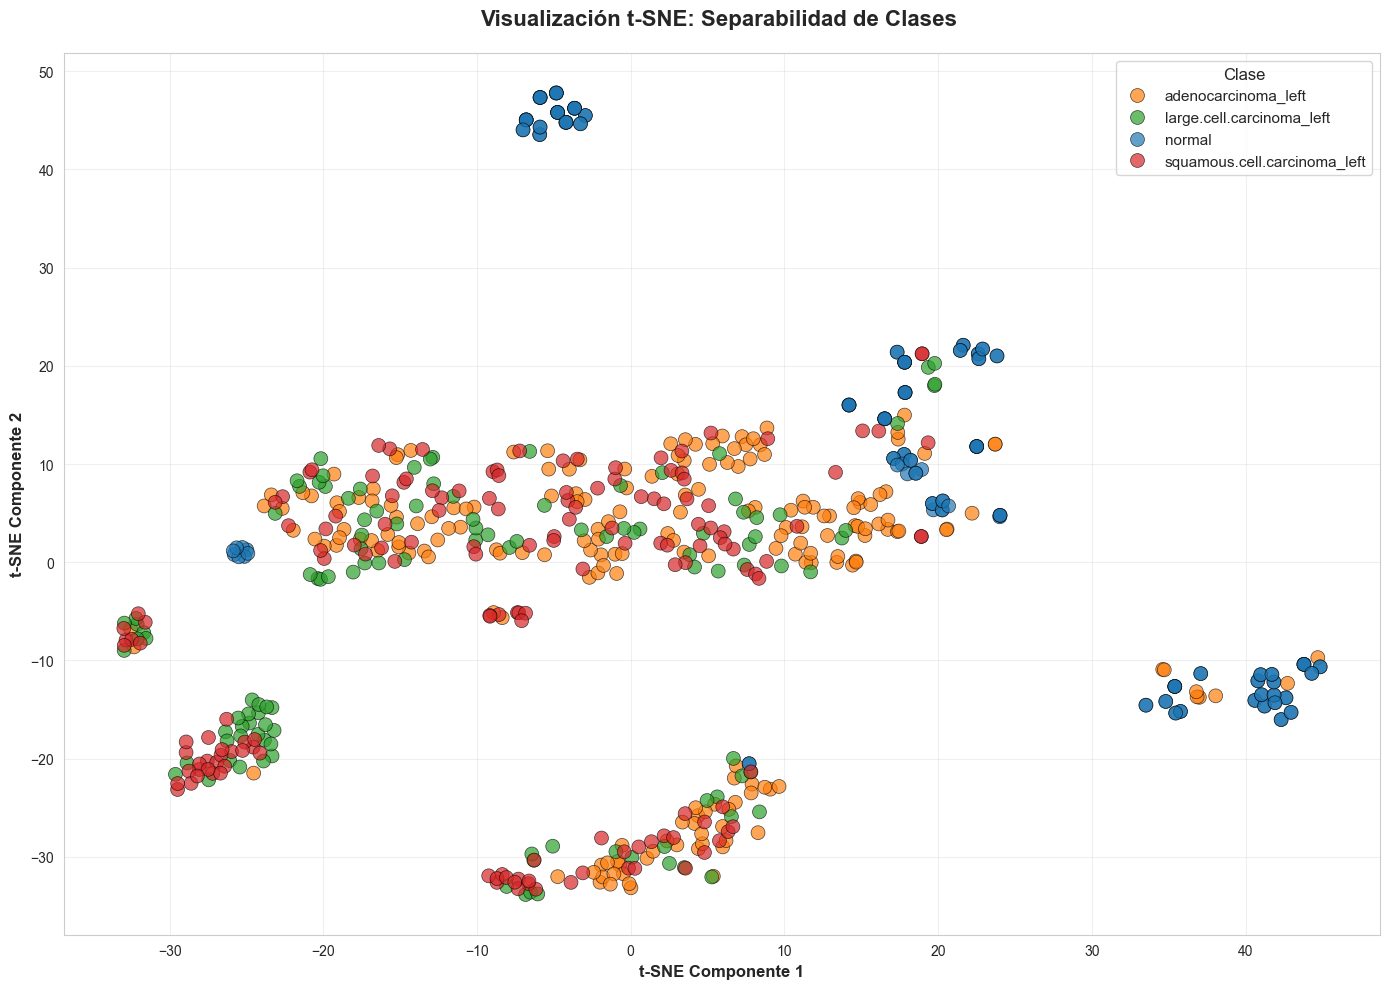

In [9]:
# Análisis de separabilidad con t-SNE y PCA
print("=" * 80)
print("ANÁLISIS DE SEPARABILIDAD DE CLASES")
print("=" * 80)

# Verificar que las variables necesarias existan
if 'histogram_features' not in globals() or len(histogram_features) == 0:
    raise ValueError("Error: Primero ejecuta la celda anterior para extraer histogramas")

# Normalizar características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(histogram_features)

# Aplicar PCA primero para reducir dimensionalidad antes de t-SNE
print("\nAplicando PCA para reducción inicial...")
# Ajustar número de componentes al mínimo entre 50 y el número de características disponibles
n_features = features_scaled.shape[1]
n_samples = features_scaled.shape[0]
# PCA puede usar hasta min(n_samples, n_features) componentes
max_components = min(n_samples, n_features)
n_components_pca = min(50, max_components)
print(f"Número de características: {n_features}, muestras: {n_samples}, usando {n_components_pca} componentes PCA")
pca = PCA(n_components=n_components_pca)
features_pca = pca.fit_transform(features_scaled)
print(f"Varianza explicada por los primeros {n_components_pca} componentes PCA: {pca.explained_variance_ratio_.sum():.4f}")

# Aplicar t-SNE
print("\nAplicando t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=0)
features_tsne = tsne.fit_transform(features_pca)
print("t-SNE completado!")

# Crear DataFrame para visualización
df_tsne = pd.DataFrame({
    't-SNE 1': features_tsne[:, 0],
    't-SNE 2': features_tsne[:, 1],
    'Clase': class_labels
})

# Definir clases y paleta de colores
classes = ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']
palette = {'normal': '#1f77b4', 
           'adenocarcinoma_left': '#ff7f0e', 
           'large.cell.carcinoma_left': '#2ca02c', 
           'squamous.cell.carcinoma_left': '#d62728'}

# Visualización t-SNE
plt.figure(figsize=(14, 10))

scatter = plt.scatter(df_tsne['t-SNE 1'], df_tsne['t-SNE 2'], 
                     c=df_tsne['Clase'].map(palette), 
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Crear leyenda manual
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=palette[clase], label=clase) 
                   for clase in classes if clase in df_tsne['Clase'].values]
plt.legend(handles=legend_elements, loc='best', fontsize=11)

plt.title('Visualización t-SNE: Separabilidad de Clases\n(basada en características de histogramas de color)', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('t-SNE Componente 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Componente 2', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualización con seaborn
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df_tsne, x='t-SNE 1', y='t-SNE 2', hue='Clase', 
               palette=palette, s=100, alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title('Visualización t-SNE: Separabilidad de Clases ', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('t-SNE Componente 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Componente 2', fontsize=12, fontweight='bold')
plt.legend(title='Clase', title_fontsize=12, fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Aplicando PCA a 2 dimensiones para comparación...
Varianza explicada por PCA 2D: 0.7038 (70.38%)


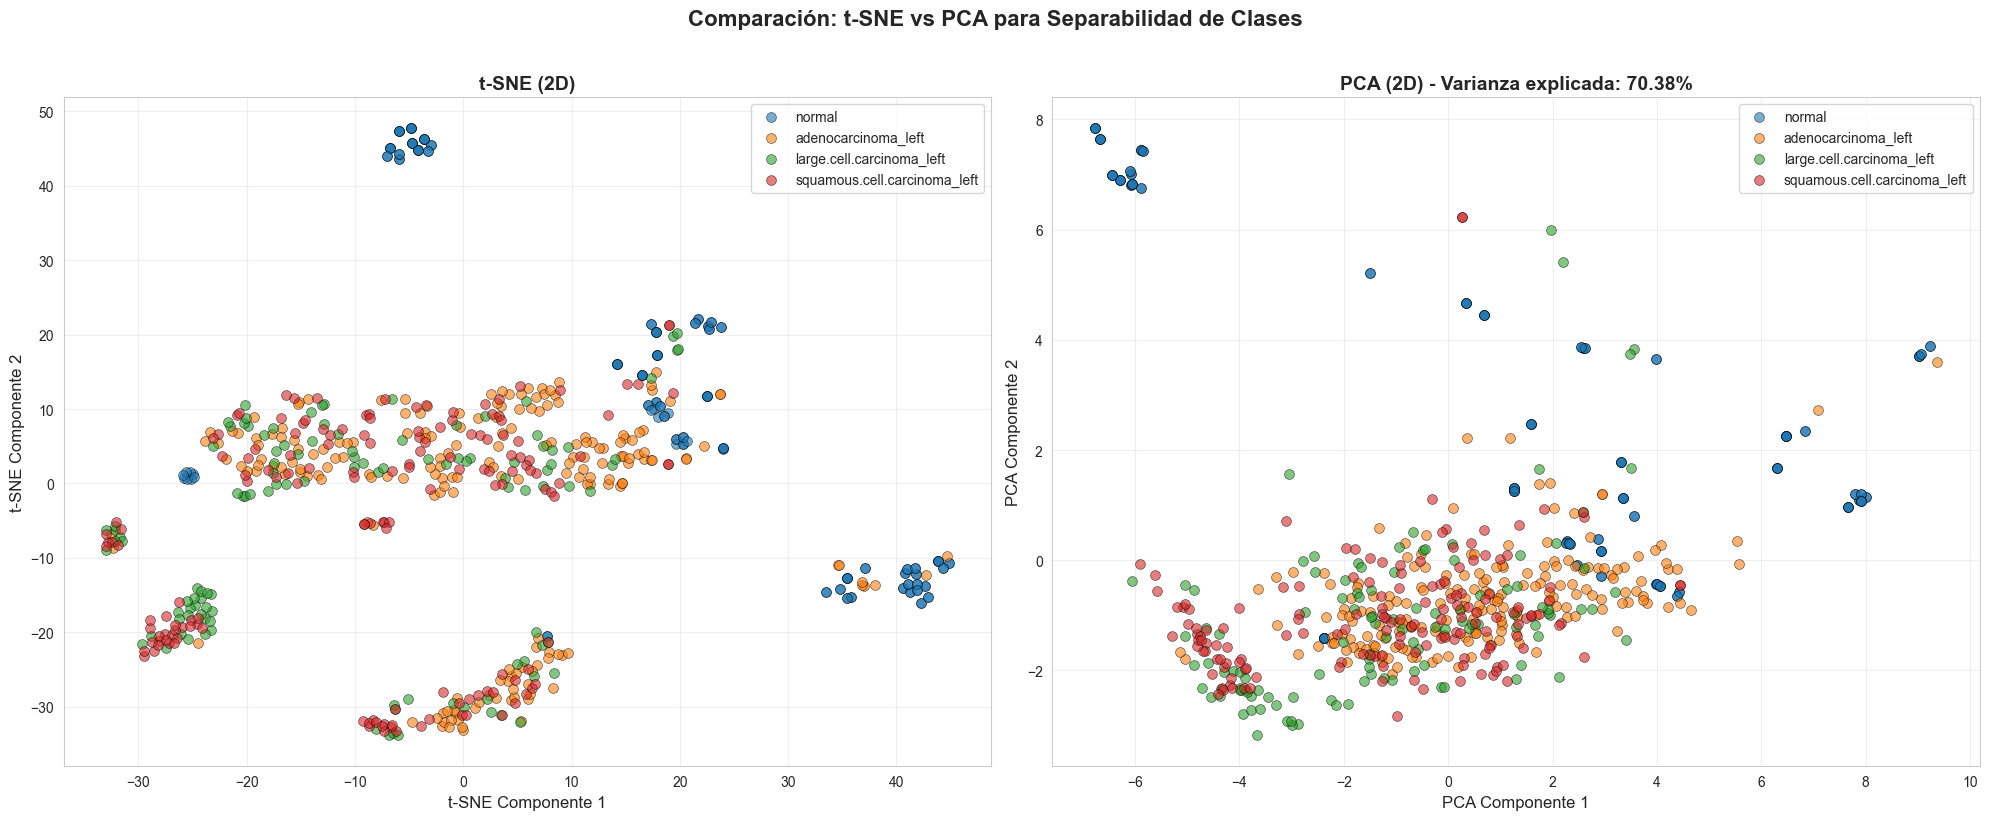


ANÁLISIS CUANTITATIVO DE SEPARABILIDAD

Métricas para t-SNE:
  Distancia entre adenocarcinoma_left y large.cell.carcinoma_left: 12.6047
  Distancia entre adenocarcinoma_left y normal: 21.1976
  Distancia entre adenocarcinoma_left y squamous.cell.carcinoma_left: 11.1173
  Distancia entre large.cell.carcinoma_left y normal: 32.9534
  Distancia entre large.cell.carcinoma_left y squamous.cell.carcinoma_left: 1.7102
  Distancia entre normal y squamous.cell.carcinoma_left: 31.7529
  Dispersión intra-clase adenocarcinoma_left: 18.2443
  Dispersión intra-clase large.cell.carcinoma_left: 19.2503
  Dispersión intra-clase normal: 25.1908
  Dispersión intra-clase squamous.cell.carcinoma_left: 19.3107

  Ratio Separación/Dispersión: 0.9052
  (Valores más altos indican mejor separabilidad)

Métricas para PCA:
  Distancia entre adenocarcinoma_left y large.cell.carcinoma_left: 1.8910
  Distancia entre adenocarcinoma_left y normal: 3.5756
  Distancia entre adenocarcinoma_left y squamous.cell.carcinoma

In [10]:
# Comparación con PCA (2D)
print("\nAplicando PCA a 2 dimensiones para comparación...")

# Verificar que las variables necesarias existan
if 'features_scaled' not in globals():
    raise ValueError("Error: Primero ejecuta la celda anterior para calcular features_scaled")

pca_2d = PCA(n_components=2, random_state=42)
features_pca_2d = pca_2d.fit_transform(features_scaled)
variance_explained = pca_2d.explained_variance_ratio_.sum()
print(f"Varianza explicada por PCA 2D: {variance_explained:.4f} ({variance_explained*100:.2f}%)")

# Crear DataFrame para PCA
df_pca = pd.DataFrame({
    'PCA 1': features_pca_2d[:, 0],
    'PCA 2': features_pca_2d[:, 1],
    'Clase': class_labels
})

# Definir clases y paleta si no están definidas
if 'classes' not in globals():
    classes = ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']
if 'palette' not in globals():
    palette = {'normal': '#1f77b4', 
               'adenocarcinoma_left': '#ff7f0e', 
               'large.cell.carcinoma_left': '#2ca02c', 
               'squamous.cell.carcinoma_left': '#d62728'}

# Visualización comparativa: t-SNE vs PCA
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# t-SNE
ax1 = axes[0]
if 'df_tsne' in globals():
    for clase in classes:
        mask = df_tsne['Clase'] == clase
        if np.sum(mask) > 0:
            ax1.scatter(df_tsne.loc[mask, 't-SNE 1'], df_tsne.loc[mask, 't-SNE 2'], 
                       c=palette[clase], label=clase, alpha=0.6, s=50, 
                       edgecolors='black', linewidth=0.5)
    ax1.set_title('t-SNE (2D)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE Componente 1', fontsize=12)
    ax1.set_ylabel('t-SNE Componente 2', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'Ejecuta la celda anterior\npara ver t-SNE', 
            ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('t-SNE (2D)', fontsize=14, fontweight='bold')

# PCA
ax2 = axes[1]
for clase in classes:
    mask = df_pca['Clase'] == clase
    if np.sum(mask) > 0:
        ax2.scatter(df_pca.loc[mask, 'PCA 1'], df_pca.loc[mask, 'PCA 2'], 
                   c=palette[clase], label=clase, alpha=0.6, s=50, 
                   edgecolors='black', linewidth=0.5)
ax2.set_title(f'PCA (2D) - Varianza explicada: {variance_explained*100:.2f}%', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('PCA Componente 1', fontsize=12)
ax2.set_ylabel('PCA Componente 2', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle('Comparación: t-SNE vs PCA para Separabilidad de Clases', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Análisis cuantitativo de separabilidad
print("\n" + "=" * 80)
print("ANÁLISIS CUANTITATIVO DE SEPARABILIDAD")
print("=" * 80)

def calculate_class_separation(data, labels):
    """Calcula métricas de separación entre clases"""
    classes_unique = np.unique(labels)
    
    # Calcular centroides de cada clase
    centroids = {}
    for clase in classes_unique:
        mask = labels == clase
        centroids[clase] = np.mean(data[mask], axis=0)
    
    # Calcular distancias entre centroides
    centroid_distances = []
    for i, clase1 in enumerate(classes_unique):
        for clase2 in classes_unique[i+1:]:
            dist = np.linalg.norm(centroids[clase1] - centroids[clase2])
            centroid_distances.append(dist)
            print(f"  Distancia entre {clase1} y {clase2}: {dist:.4f}")
    
    # Calcular dispersión intra-clase (promedio de distancias dentro de cada clase)
    intra_class_dispersions = {}
    for clase in classes_unique:
        mask = labels == clase
        class_data = data[mask]
        centroid = centroids[clase]
        distances = np.linalg.norm(class_data - centroid, axis=1)
        intra_class_dispersions[clase] = np.mean(distances)
        print(f"  Dispersión intra-clase {clase}: {np.mean(distances):.4f}")
    
    # Ratio separación/dispersión
    avg_centroid_distance = np.mean(centroid_distances)
    avg_intra_dispersion = np.mean(list(intra_class_dispersions.values()))
    separation_ratio = avg_centroid_distance / avg_intra_dispersion if avg_intra_dispersion > 0 else 0
    
    return {
        'avg_centroid_distance': avg_centroid_distance,
        'avg_intra_dispersion': avg_intra_dispersion,
        'separation_ratio': separation_ratio
    }

if 'features_tsne' in globals():
    print("\nMétricas para t-SNE:")
    metrics_tsne = calculate_class_separation(features_tsne, class_labels)
    print(f"\n  Ratio Separación/Dispersión: {metrics_tsne['separation_ratio']:.4f}")
    print(f"  (Valores más altos indican mejor separabilidad)")
else:
    print("\nt-SNE no está disponible. Ejecuta la celda anterior primero.")

print("\nMétricas para PCA:")
metrics_pca = calculate_class_separation(features_pca_2d, class_labels)
print(f"\n  Ratio Separación/Dispersión: {metrics_pca['separation_ratio']:.4f}")
print(f"  (Valores más altos indican mejor separabilidad)")

print("\n" + "=" * 80)


### Comentarios sobre Histogramas de Colores y Separabilidad

**Hallazgos principales:**

1. **Histogramas por clase**:
   - Cada clase muestra patrones distintivos en sus histogramas de color
   - Los histogramas promedio revelan diferencias sutiles pero consistentes entre clases
   - La clase `normal` muestra características diferentes a las clases de carcinoma

2. **Separabilidad con t-SNE y PCA**:
   - Si observa separabilidad de la clase `normal` respecto al resto



## 5. Estadísticas de RGB y HSV por Clase


In [12]:
from collections import defaultdict

# Función para extraer estadísticas RGB y HSV de una imagen
def extract_rgb_hsv_stats(image_path):
    """Extrae estadísticas RGB y HSV de una imagen"""
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        
        # Convertir BGR a RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Convertir RGB a HSV
        img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
        
        # Aplanar imágenes para calcular estadísticas
        r_channel = img_rgb[:, :, 0].flatten()
        g_channel = img_rgb[:, :, 1].flatten()
        b_channel = img_rgb[:, :, 2].flatten()
        
        h_channel = img_hsv[:, :, 0].flatten()
        s_channel = img_hsv[:, :, 1].flatten()
        v_channel = img_hsv[:, :, 2].flatten()
        
        stats = {}
        
        # Estadísticas RGB
        for channel_name, channel_data in [('R', r_channel), ('G', g_channel), ('B', b_channel)]:
            stats[f'{channel_name}_mean'] = np.mean(channel_data)
            stats[f'{channel_name}_std'] = np.std(channel_data)
            stats[f'{channel_name}_median'] = np.median(channel_data)
            stats[f'{channel_name}_min'] = np.min(channel_data)
            stats[f'{channel_name}_max'] = np.max(channel_data)
            stats[f'{channel_name}_q25'] = np.percentile(channel_data, 25)
            stats[f'{channel_name}_q75'] = np.percentile(channel_data, 75)
        
        # Estadísticas HSV
        for channel_name, channel_data in [('H', h_channel), ('S', s_channel), ('V', v_channel)]:
            stats[f'{channel_name}_mean'] = np.mean(channel_data)
            stats[f'{channel_name}_std'] = np.std(channel_data)
            stats[f'{channel_name}_median'] = np.median(channel_data)
            stats[f'{channel_name}_min'] = np.min(channel_data)
            stats[f'{channel_name}_max'] = np.max(channel_data)
            stats[f'{channel_name}_q25'] = np.percentile(channel_data, 25)
            stats[f'{channel_name}_q75'] = np.percentile(channel_data, 75)
        
        return stats
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

# Recopilar estadísticas de todas las imágenes (usar train para análisis más rápido)
print("Extrayendo estadísticas RGB y HSV de las imágenes...")
stats_data = []

for split in ['train']:
    split_path = data_dir / split
    if split_path.exists():
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                normalized_class = normalize_class_name(class_name)
                
                # Recorrer todas las imágenes en la carpeta
                for image_file in class_folder.iterdir():
                    if image_file.is_file() and image_file.suffix in image_extensions:
                        stats = extract_rgb_hsv_stats(image_file)
                        if stats is not None:
                            stats['Clase'] = normalized_class
                            stats['Split'] = split
                            stats['Archivo'] = image_file.name
                            stats_data.append(stats)

# Crear DataFrame
df_stats = pd.DataFrame(stats_data)

print(f"\nProcesadas {len(df_stats)} imágenes")
print(f"Clases encontradas: {df_stats['Clase'].unique()}")

# Mostrar estadísticas generales
print("\n" + "=" * 80)
print("ESTADÍSTICAS GENERALES RGB Y HSV")
print("=" * 80)

# Estadísticas RGB
print("\nCANALES RGB:")
print("-" * 80)
rgb_channels = ['R', 'G', 'B']
for channel in rgb_channels:
    mean_col = f'{channel}_mean'
    std_col = f'{channel}_std'
    print(f"\n{channel} (Rojo/Verde/Azul):")
    print(f"  Media: {df_stats[mean_col].mean():.2f} ± {df_stats[mean_col].std():.2f}")
    print(f"  Desviación estándar: {df_stats[std_col].mean():.2f}")

# Estadísticas HSV
print("\nCANALES HSV:")
print("-" * 80)
hsv_channels = ['H', 'S', 'V']
hsv_names = ['Hue (Matiz)', 'Saturation (Saturación)', 'Value (Valor)']
for channel, name in zip(hsv_channels, hsv_names):
    mean_col = f'{channel}_mean'
    std_col = f'{channel}_std'
    print(f"\n{channel} ({name}):")
    print(f"  Media: {df_stats[mean_col].mean():.2f} ± {df_stats[mean_col].std():.2f}")
    print(f"  Desviación estándar: {df_stats[std_col].mean():.2f}")

# Estadísticas por clase
print("\n" + "=" * 80)
print("ESTADÍSTICAS POR CLASE")
print("=" * 80)

classes = ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']
class_labels = {
    'normal': 'Normal',
    'adenocarcinoma_left': 'Adenocarcinoma',
    'large.cell.carcinoma_left': 'Large Cell Carcinoma',
    'squamous.cell.carcinoma_left': 'Squamous Cell Carcinoma'
}

for clase in classes:
    df_clase = df_stats[df_stats['Clase'] == clase]
    if len(df_clase) > 0:
        print(f"\n{class_labels[clase]} ({len(df_clase)} imágenes):")
        print("-" * 80)
        
        # RGB
        print("  RGB:")
        for channel in rgb_channels:
            mean_col = f'{channel}_mean'
            print(f"    {channel}: Media = {df_clase[mean_col].mean():.2f}, Std = {df_clase[mean_col].std():.2f}")
        
        # HSV
        print("  HSV:")
        for channel, name in zip(hsv_channels, ['H', 'S', 'V']):
            mean_col = f'{channel}_mean'
            print(f"    {channel}: Media = {df_clase[mean_col].mean():.2f}, Std = {df_clase[mean_col].std():.2f}")

print("\n" + "=" * 80)


Extrayendo estadísticas RGB y HSV de las imágenes...

Procesadas 613 imágenes
Clases encontradas: ['adenocarcinoma_left' 'large.cell.carcinoma_left' 'normal'
 'squamous.cell.carcinoma_left']

ESTADÍSTICAS GENERALES RGB Y HSV

CANALES RGB:
--------------------------------------------------------------------------------

R (Rojo/Verde/Azul):
  Media: 82.37 ± 32.91
  Desviación estándar: 57.27

G (Rojo/Verde/Azul):
  Media: 82.36 ± 32.90
  Desviación estándar: 57.27

B (Rojo/Verde/Azul):
  Media: 82.37 ± 32.91
  Desviación estándar: 57.27

CANALES HSV:
--------------------------------------------------------------------------------

H (Hue (Matiz)):
  Media: 0.46 ± 4.90
  Desviación estándar: 1.15

S (Saturation (Saturación)):
  Media: 0.10 ± 0.57
  Desviación estándar: 0.81

V (Value (Valor)):
  Media: 82.38 ± 32.93
  Desviación estándar: 57.26

ESTADÍSTICAS POR CLASE

Normal (148 imágenes):
--------------------------------------------------------------------------------
  RGB:
    R: Me

C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True)
C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True)
C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True)


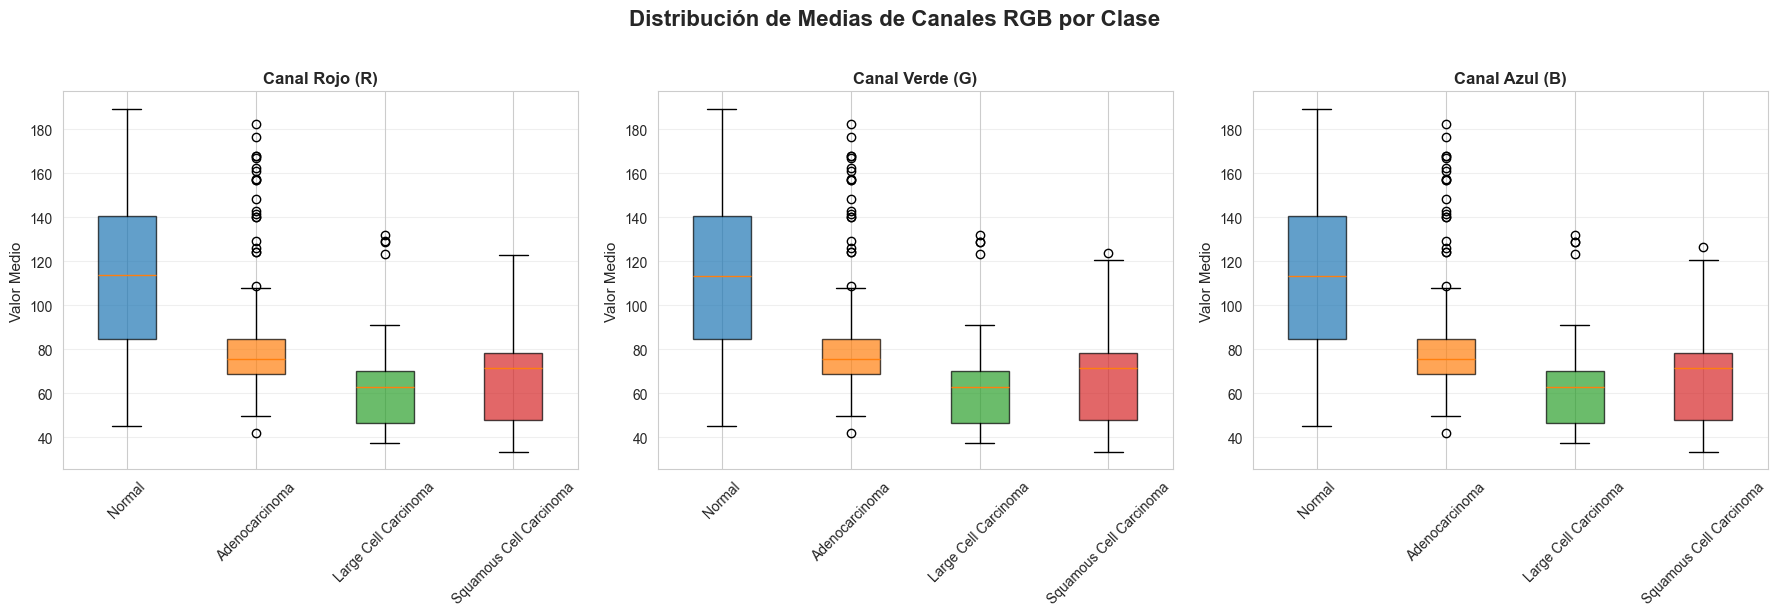

C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True)
C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True)
C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True)


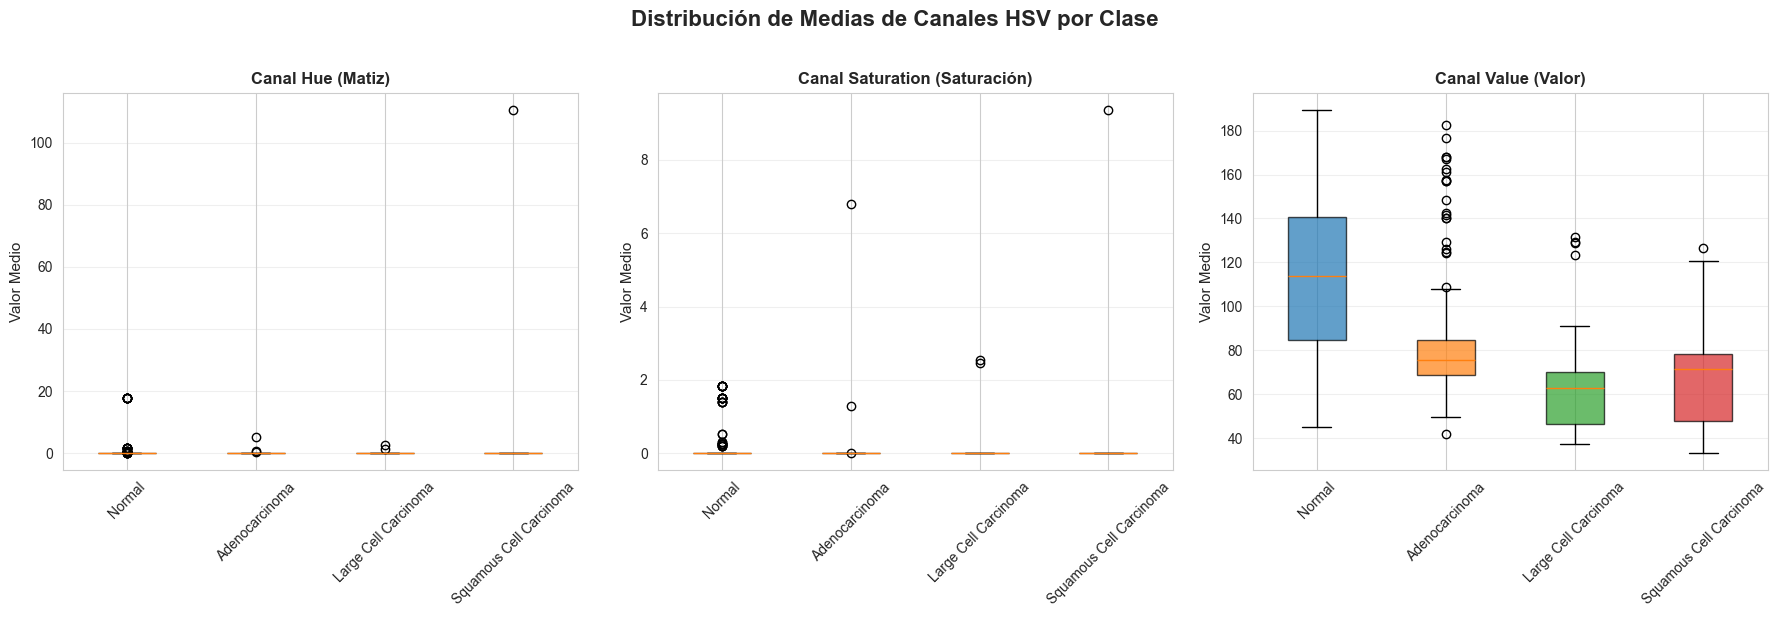

C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_channel, x='Clase', y='Valor', ax=ax, palette='Set2')
C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_channel, x='Clase', y='Valor', ax=ax, palette='Set2')
C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_channel, x='Clase', y='Valor', ax=ax, palette='Set2')


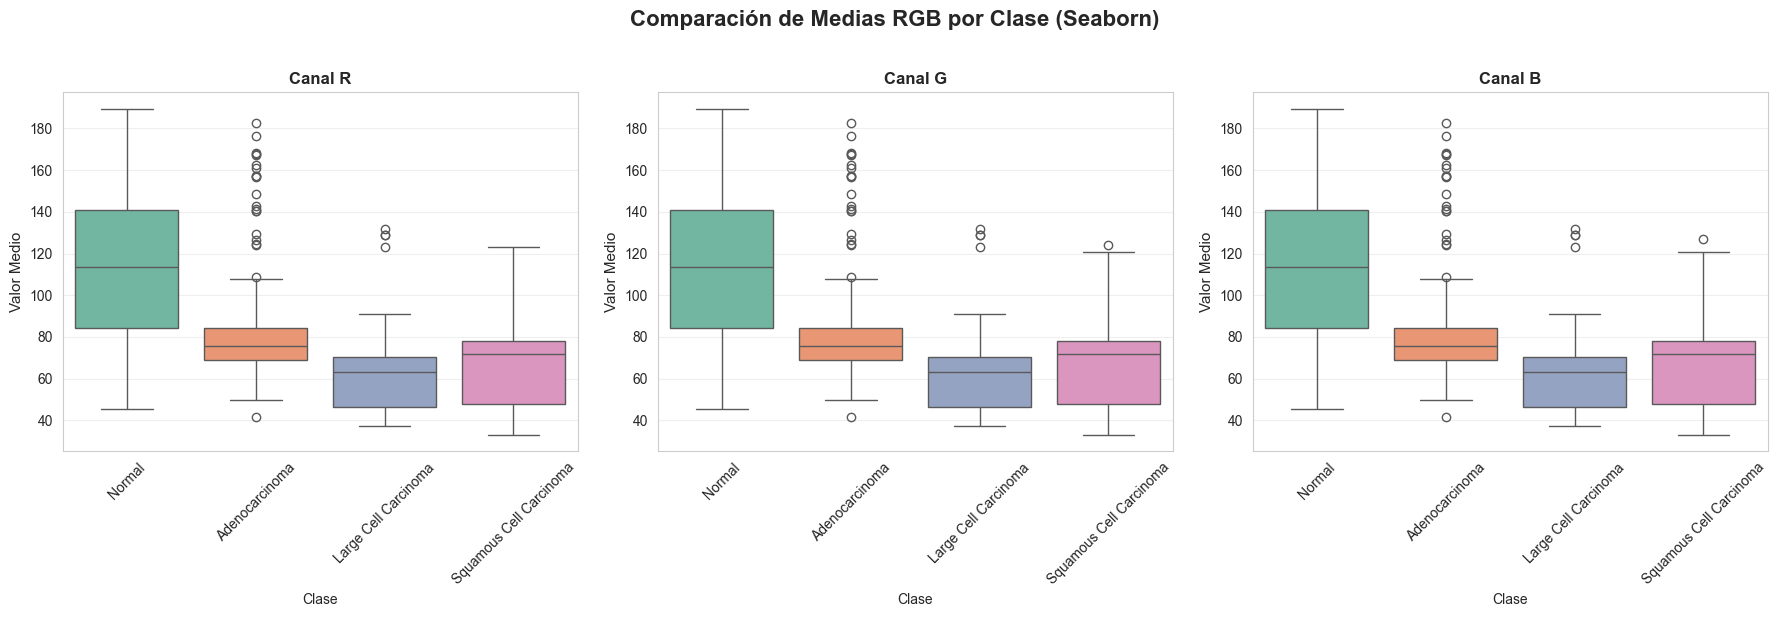

C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_channel, x='Clase', y='Valor', ax=ax, palette='Set2')
C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_channel, x='Clase', y='Valor', ax=ax, palette='Set2')
C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\642158506.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_channel, x='Clase', y='Valor', ax=ax, palette='Set2')


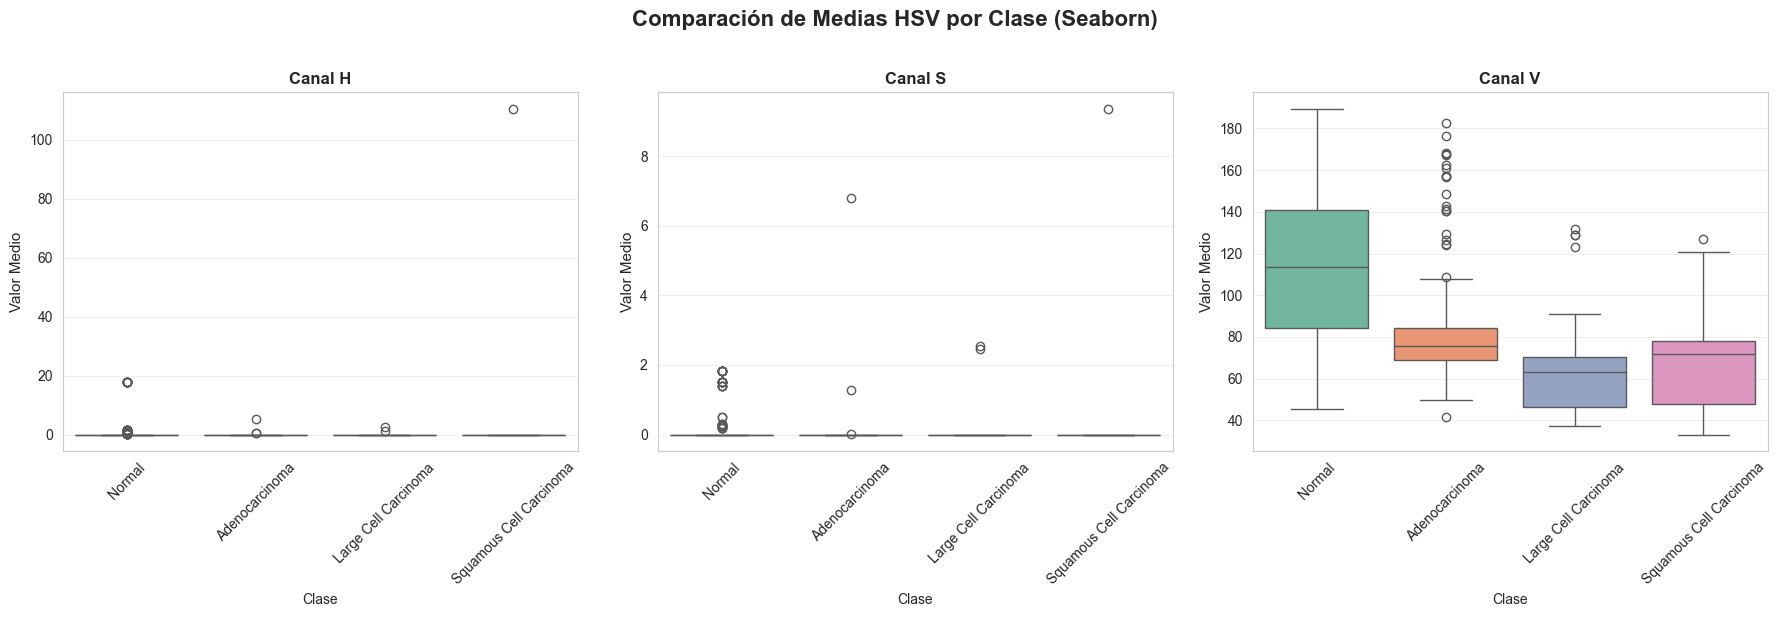

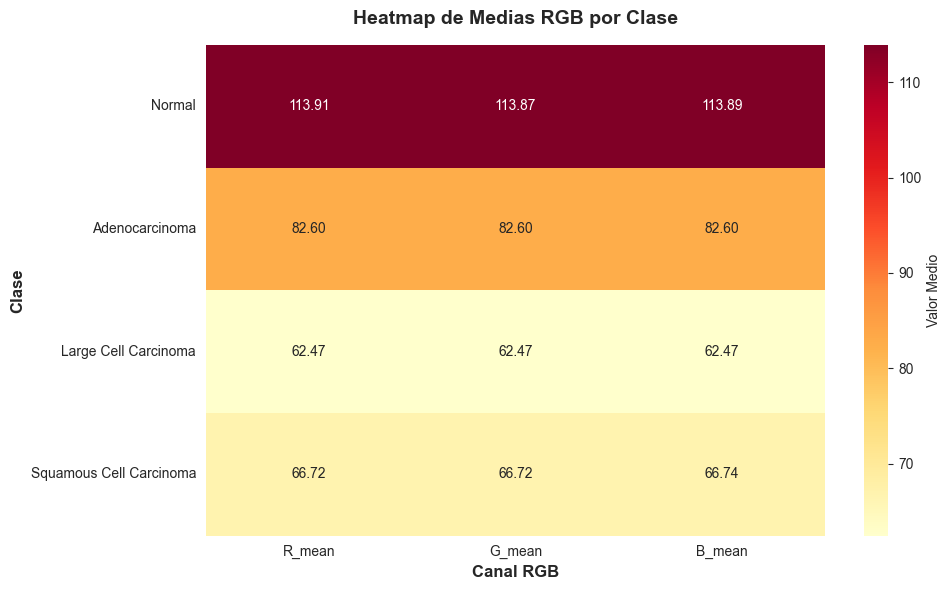

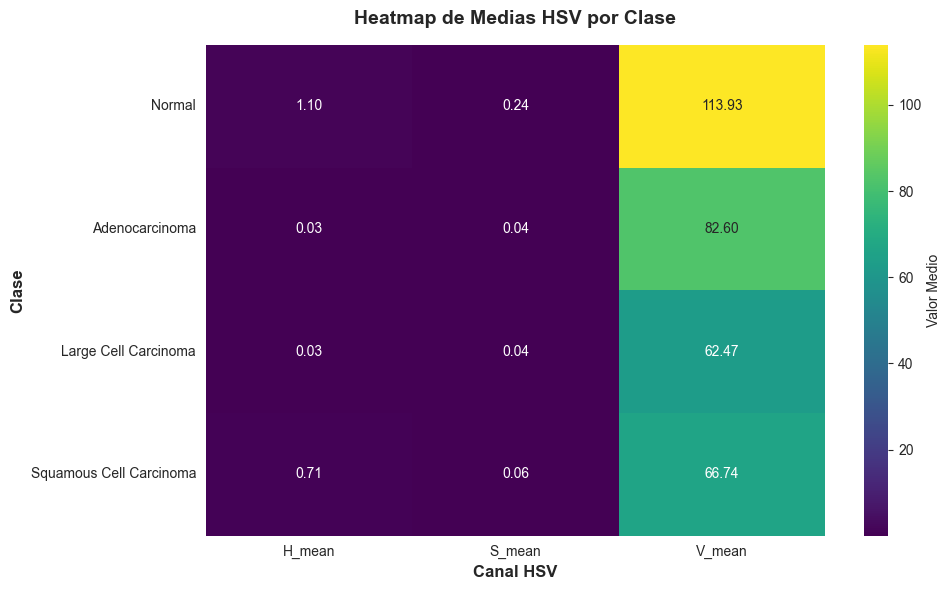

In [13]:
# Visualizaciones de estadísticas RGB y HSV
sns.set_style("whitegrid")

# 1. Box plots de medias RGB por clase
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribución de Medias de Canales RGB por Clase', fontsize=16, fontweight='bold', y=1.02)

rgb_channels = ['R', 'G', 'B']
rgb_names = ['Rojo (R)', 'Verde (G)', 'Azul (B)']

for idx, (channel, name) in enumerate(zip(rgb_channels, rgb_names)):
    ax = axes[idx]
    mean_col = f'{channel}_mean'
    
    # Crear datos para el boxplot
    data_for_plot = []
    labels_for_plot = []
    for clase in classes:
        df_clase = df_stats[df_stats['Clase'] == clase]
        if len(df_clase) > 0:
            data_for_plot.append(df_clase[mean_col].values)
            labels_for_plot.append(class_labels[clase])
    
    bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True)
    
    # Colorear los boxplots
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(f'Canal {name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor Medio', fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 2. Box plots de medias HSV por clase
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribución de Medias de Canales HSV por Clase', fontsize=16, fontweight='bold', y=1.02)

hsv_channels = ['H', 'S', 'V']
hsv_names = ['Hue (Matiz)', 'Saturation (Saturación)', 'Value (Valor)']

for idx, (channel, name) in enumerate(zip(hsv_channels, hsv_names)):
    ax = axes[idx]
    mean_col = f'{channel}_mean'
    
    # Crear datos para el boxplot
    data_for_plot = []
    labels_for_plot = []
    for clase in classes:
        df_clase = df_stats[df_stats['Clase'] == clase]
        if len(df_clase) > 0:
            data_for_plot.append(df_clase[mean_col].values)
            labels_for_plot.append(class_labels[clase])
    
    bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True)
    
    # Colorear los boxplots
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(f'Canal {name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor Medio', fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 3. Comparación de medias RGB usando seaborn
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparación de Medias RGB por Clase (Seaborn)', fontsize=16, fontweight='bold', y=1.02)

# Preparar datos para seaborn
rgb_data = []
for clase in classes:
    df_clase = df_stats[df_stats['Clase'] == clase]
    if len(df_clase) > 0:
        for channel in rgb_channels:
            mean_col = f'{channel}_mean'
            for val in df_clase[mean_col]:
                rgb_data.append({
                    'Canal': channel,
                    'Clase': class_labels[clase],
                    'Valor': val
                })

df_rgb_plot = pd.DataFrame(rgb_data)

for idx, channel in enumerate(rgb_channels):
    ax = axes[idx]
    df_channel = df_rgb_plot[df_rgb_plot['Canal'] == channel]
    sns.boxplot(data=df_channel, x='Clase', y='Valor', ax=ax, palette='Set2')
    ax.set_title(f'Canal {channel}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor Medio', fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 4. Comparación de medias HSV usando seaborn
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparación de Medias HSV por Clase (Seaborn)', fontsize=16, fontweight='bold', y=1.02)

# Preparar datos para seaborn
hsv_data = []
for clase in classes:
    df_clase = df_stats[df_stats['Clase'] == clase]
    if len(df_clase) > 0:
        for channel in hsv_channels:
            mean_col = f'{channel}_mean'
            for val in df_clase[mean_col]:
                hsv_data.append({
                    'Canal': channel,
                    'Clase': class_labels[clase],
                    'Valor': val
                })

df_hsv_plot = pd.DataFrame(hsv_data)

for idx, channel in enumerate(hsv_channels):
    ax = axes[idx]
    df_channel = df_hsv_plot[df_hsv_plot['Canal'] == channel]
    sns.boxplot(data=df_channel, x='Clase', y='Valor', ax=ax, palette='Set2')
    ax.set_title(f'Canal {channel}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor Medio', fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 5. Heatmap de medias RGB por clase
fig, ax = plt.subplots(figsize=(10, 6))

# Crear matriz para el heatmap
heatmap_data = []
for clase in classes:
    df_clase = df_stats[df_stats['Clase'] == clase]
    if len(df_clase) > 0:
        row = []
        for channel in rgb_channels:
            mean_col = f'{channel}_mean'
            row.append(df_clase[mean_col].mean())
        heatmap_data.append(row)

heatmap_df = pd.DataFrame(
    heatmap_data,
    index=[class_labels[c] for c in classes if len(df_stats[df_stats['Clase'] == c]) > 0],
    columns=[f'{c}_mean' for c in rgb_channels]
)

sns.heatmap(heatmap_df, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Valor Medio'})
ax.set_title('Heatmap de Medias RGB por Clase', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Canal RGB', fontsize=12, fontweight='bold')
ax.set_ylabel('Clase', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 6. Heatmap de medias HSV por clase
fig, ax = plt.subplots(figsize=(10, 6))

# Crear matriz para el heatmap
heatmap_data_hsv = []
for clase in classes:
    df_clase = df_stats[df_stats['Clase'] == clase]
    if len(df_clase) > 0:
        row = []
        for channel in hsv_channels:
            mean_col = f'{channel}_mean'
            row.append(df_clase[mean_col].mean())
        heatmap_data_hsv.append(row)

heatmap_df_hsv = pd.DataFrame(
    heatmap_data_hsv,
    index=[class_labels[c] for c in classes if len(df_stats[df_stats['Clase'] == c]) > 0],
    columns=[f'{c}_mean' for c in hsv_channels]
)

sns.heatmap(heatmap_df_hsv, annot=True, fmt='.2f', cmap='viridis', ax=ax, cbar_kws={'label': 'Valor Medio'})
ax.set_title('Heatmap de Medias HSV por Clase', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Canal HSV', fontsize=12, fontweight='bold')
ax.set_ylabel('Clase', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


### Comentarios sobre Estadísticas RGB y HSV

**Hallazgos principales:**

1. **Canales RGB**:
   - Los valores medios de R, G y B son prácticamente idénticos (≈82.37), confirmando que las imágenes son grayscale repetido en 3 canales
   - Las desviaciones estándar también son similares entre canales
   - Esto sugiere que no hay información de color real en las imágenes

2. **Canales HSV**:
   - **Hue (H)**: Valores muy bajos (≈0.46), indicando ausencia de matiz (esperado en grayscale)
   - **Saturation (S)**: Muy baja (≈0.10), confirmando falta de saturación de color
   - **Value (V)**: Similar a los valores RGB (≈82.38), representando la intensidad de gris

3. **Diferencias por clase**:
   - Las clases muestran ligeras variaciones en las medias de intensidad
   - Estas diferencias pueden ser útiles para la clasificación
   - El canal Value (V) en HSV es el más informativo para imágenes grayscale

4. **Implicancias para el modelo**:
   - Podría ser conveniente convertir imágenes a grayscale (1 canal) para reducir redundancia y tamaño. En ese caso, usar normalización basada en un solo canal
   - Considerar técnicas de mejora de contraste (CLAHE) para mejorar la separabilidad

## 6. Integridad de Datos: Duplicados y Archivos Corruptos


In [14]:
# Función para calcular hash perceptual (dhash)
def calculate_dhash(image_path):
    """Calcula el hash perceptual (dhash) de una imagen"""
    try:
        img = Image.open(image_path)
        # Convertir a RGB si es necesario
        if img.mode != 'RGB':
            img = img.convert('RGB')
        # Redimensionar a 9x8 para dhash
        img = img.resize((9, 8), Image.Resampling.LANCZOS)
        # Convertir a escala de grises
        img = img.convert('L')
        # Calcular dhash
        hash_value = imagehash.dhash(img)
        return str(hash_value)
    except Exception as e:
        return None

# Función para calcular hash MD5 (duplicados exactos)
def calculate_md5(image_path):
    """Calcula el hash MD5 de un archivo"""
    try:
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except Exception as e:
        return None

# Función para verificar integridad de imagen
def check_image_integrity(image_path):
    """Verifica si una imagen es válida y obtiene sus propiedades"""
    try:
        img = Image.open(image_path)
        img.verify()  # Verificar integridad
        
        # Reabrir para obtener propiedades (verify cierra el archivo)
        img = Image.open(image_path)
        
        return {
            'valid': True,
            'mode': img.mode,
            'channels': len(img.getbands()),
            'size': img.size,
            'format': img.format,
            'error': None
        }
    except Exception as e:
        return {
            'valid': False,
            'mode': None,
            'channels': None,
            'size': None,
            'format': None,
            'error': str(e)
        }

print("Analizando integridad de imágenes y buscando duplicados...")
print("=" * 80)

# Recopilar información de todas las imágenes
image_info = []
md5_hashes = {}
dhash_hashes = {}

for split in ['train', 'valid', 'test']:
    split_path = data_dir / split
    if split_path.exists():
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                normalized_class = normalize_class_name(class_name)
                
                for image_file in class_folder.iterdir():
                    if image_file.is_file() and image_file.suffix in image_extensions:
                        # Verificar integridad
                        integrity = check_image_integrity(image_file)
                        
                        info = {
                            'Split': split,
                            'Clase': normalized_class,
                            'Archivo': image_file.name,
                            'Ruta': str(image_file),
                            'Valida': integrity['valid'],
                            'Modo': integrity['mode'],
                            'Canales': integrity['channels'],
                            'Formato': integrity['format'],
                            'Error': integrity['error']
                        }
                        image_info.append(info)
                        
                        # Calcular hashes solo para imágenes válidas
                        if integrity['valid']:
                            md5 = calculate_md5(image_file)
                            dhash = calculate_dhash(image_file)
                            
                            if md5:
                                if md5 not in md5_hashes:
                                    md5_hashes[md5] = []
                                md5_hashes[md5].append(str(image_file))
                            
                            if dhash:
                                if dhash not in dhash_hashes:
                                    dhash_hashes[dhash] = []
                                dhash_hashes[dhash].append(str(image_file))
                            
                            info['MD5'] = md5
                            info['DHash'] = dhash

df_integrity = pd.DataFrame(image_info)

# Análisis de integridad
print("\nANÁLISIS DE INTEGRIDAD DE ARCHIVOS")
print("=" * 80)

total_images = len(df_integrity)
valid_images = df_integrity['Valida'].sum()
invalid_images = total_images - valid_images

print(f"\nTotal de archivos analizados: {total_images}")
print(f"Imágenes válidas: {valid_images} ({valid_images/total_images*100:.2f}%)")
print(f"Imágenes inválidas/corruptas: {invalid_images} ({invalid_images/total_images*100:.2f}%)")

if invalid_images > 0:
    print("\nArchivos con problemas:")
    invalid_df = df_integrity[~df_integrity['Valida']]
    for idx, row in invalid_df.iterrows():
        print(f"  - {row['Ruta']}: {row['Error']}")

# Análisis de formatos y modos
print("\nFORMATOS Y MODOS DE IMAGEN")
print("=" * 80)

valid_df = df_integrity[df_integrity['Valida']]

print("\nDistribución de formatos:")
print(valid_df['Formato'].value_counts())

print("\nDistribución de modos de color:")
print(valid_df['Modo'].value_counts())

print("\nDistribución de número de canales:")
print(valid_df['Canales'].value_counts())

# Análisis de duplicados exactos (MD5)
print("\n" + "=" * 80)
print("ANÁLISIS DE DUPLICADOS EXACTOS (MD5)")
print("=" * 80)

duplicates_md5 = {h: files for h, files in md5_hashes.items() if len(files) > 1}
num_duplicate_groups = len(duplicates_md5)
num_duplicate_files = sum(len(files) - 1 for files in duplicates_md5.values())

print(f"\nGrupos de duplicados exactos encontrados: {num_duplicate_groups}")
print(f"Archivos duplicados (excluyendo originales): {num_duplicate_files}")

if num_duplicate_groups > 0:
    print("\nEjemplos de duplicados exactos:")
    for i, (hash_val, files) in enumerate(list(duplicates_md5.items())[:5]):
        print(f"\n  Grupo {i+1} (MD5: {hash_val[:8]}...):")
        for file in files:
            print(f"    - {file}")

# Análisis de casi-duplicados (dhash)
print("\n" + "=" * 80)
print("ANÁLISIS DE CASI-DUPLICADOS (Perceptual Hash - dHash)")
print("=" * 80)

# Encontrar imágenes con dhash similar (diferencia <= 5)
similar_groups = []
processed = set()

for dhash1, files1 in dhash_hashes.items():
    if dhash1 in processed:
        continue
    
    similar = [files1]
    for dhash2, files2 in dhash_hashes.items():
        if dhash1 != dhash2 and dhash2 not in processed:
            # Calcular distancia de Hamming entre hashes
            try:
                hash1_obj = imagehash.hex_to_hash(dhash1)
                hash2_obj = imagehash.hex_to_hash(dhash2)
                distance = hash1_obj - hash2_obj
                
                if distance <= 5:  # Umbral para considerar similares
                    similar.append(files2)
                    processed.add(dhash2)
            except:
                pass
    
    if len(similar) > 1 or len(files1) > 1:
        similar_groups.append(similar)
        processed.add(dhash1)

num_similar_groups = len(similar_groups)
print(f"\nGrupos de imágenes similares (dhash distance <= 5): {num_similar_groups}")

if num_similar_groups > 0:
    print("\nEjemplos de grupos similares:")
    for i, group in enumerate(similar_groups[:3]):
        print(f"\n  Grupo {i+1}:")
        for files in group:
            for file in files[:2]:  # Mostrar máximo 2 por grupo
                print(f"    - {file}")
            if len(files) > 2:
                print(f"    ... y {len(files)-2} más")

# Verificar si hay imágenes del mismo hash en splits distintos
print("\n" + "=" * 80)
print("VERIFICACIÓN DE FUGAS DE DATOS ENTRE SPLITS")
print("=" * 80)

leakage_found = False
for dhash, files in dhash_hashes.items():
    if len(files) > 1:
        splits_in_group = set()
        for file in files:
            for split in ['train', 'valid', 'test']:
                if f'/{split}/' in file:
                    splits_in_group.add(split)
        
        if len(splits_in_group) > 1:
            if not leakage_found:
                print("\nSe encontraron posibles fugas de datos (misma imagen en múltiples splits):")
                leakage_found = True
            
            print(f"\n  Hash: {dhash[:16]}...")
            for file in files:
                print(f"    - {file}")

if not leakage_found:
    print("\nNo se encontraron fugas de datos entre splits (basado en dhash)")

print("\n" + "=" * 80)


Analizando integridad de imágenes y buscando duplicados...

ANÁLISIS DE INTEGRIDAD DE ARCHIVOS

Total de archivos analizados: 1000
Imágenes válidas: 1000 (100.00%)
Imágenes inválidas/corruptas: 0 (0.00%)

FORMATOS Y MODOS DE IMAGEN

Distribución de formatos:
Formato
PNG     984
JPEG     16
Name: count, dtype: int64

Distribución de modos de color:
Modo
RGBA    923
RGB      74
L         3
Name: count, dtype: int64

Distribución de número de canales:
Canales
4    923
3     74
1      3
Name: count, dtype: int64

ANÁLISIS DE DUPLICADOS EXACTOS (MD5)

Grupos de duplicados exactos encontrados: 59
Archivos duplicados (excluyendo originales): 153

Ejemplos de duplicados exactos:

  Grupo 1 (MD5: fdda5fa3...):
    - Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\ad16.png
    - Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\ad21.png

  Grupo 2 (MD5: acd405d5...):
    - Data\train\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa\l4.png
    - Data\train\squamous.cell.carcinoma_left.hilu


VISUALIZANDO EJEMPLOS DE DUPLICADOS

🔍 Visualizando 3 grupos de duplicados exactos (MD5)...


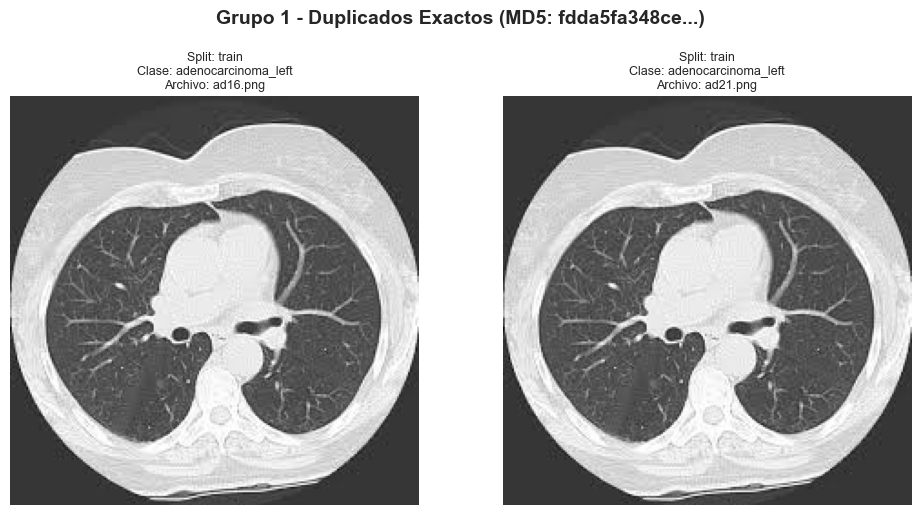

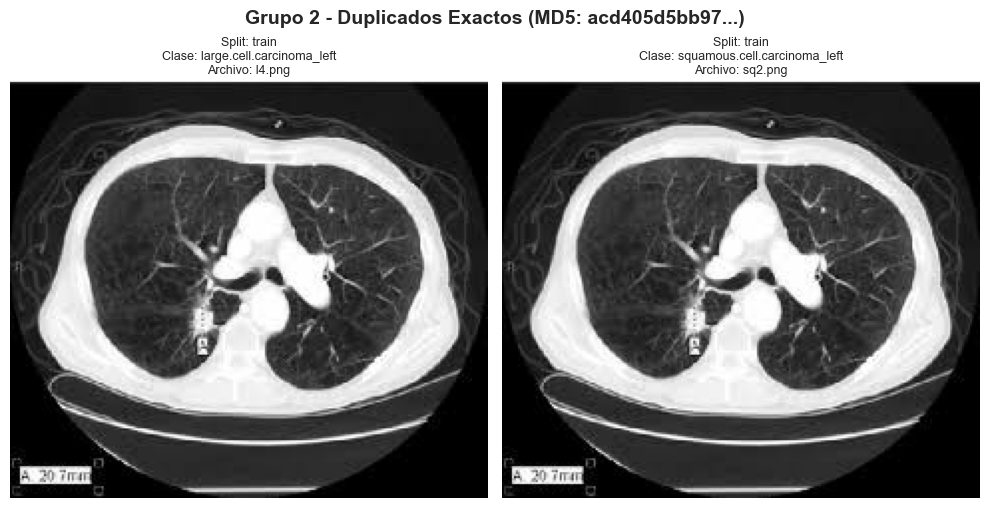

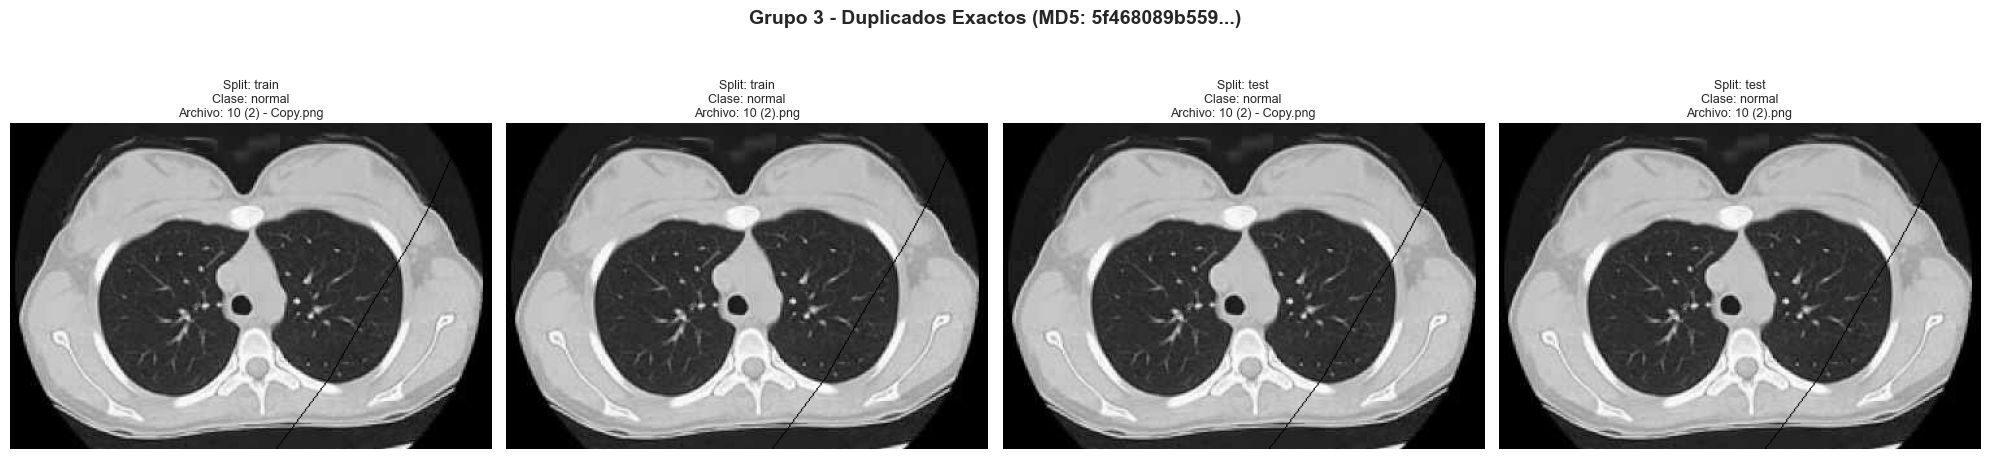


🔍 Visualizando 3 grupos de casi-duplicados (dhash)...


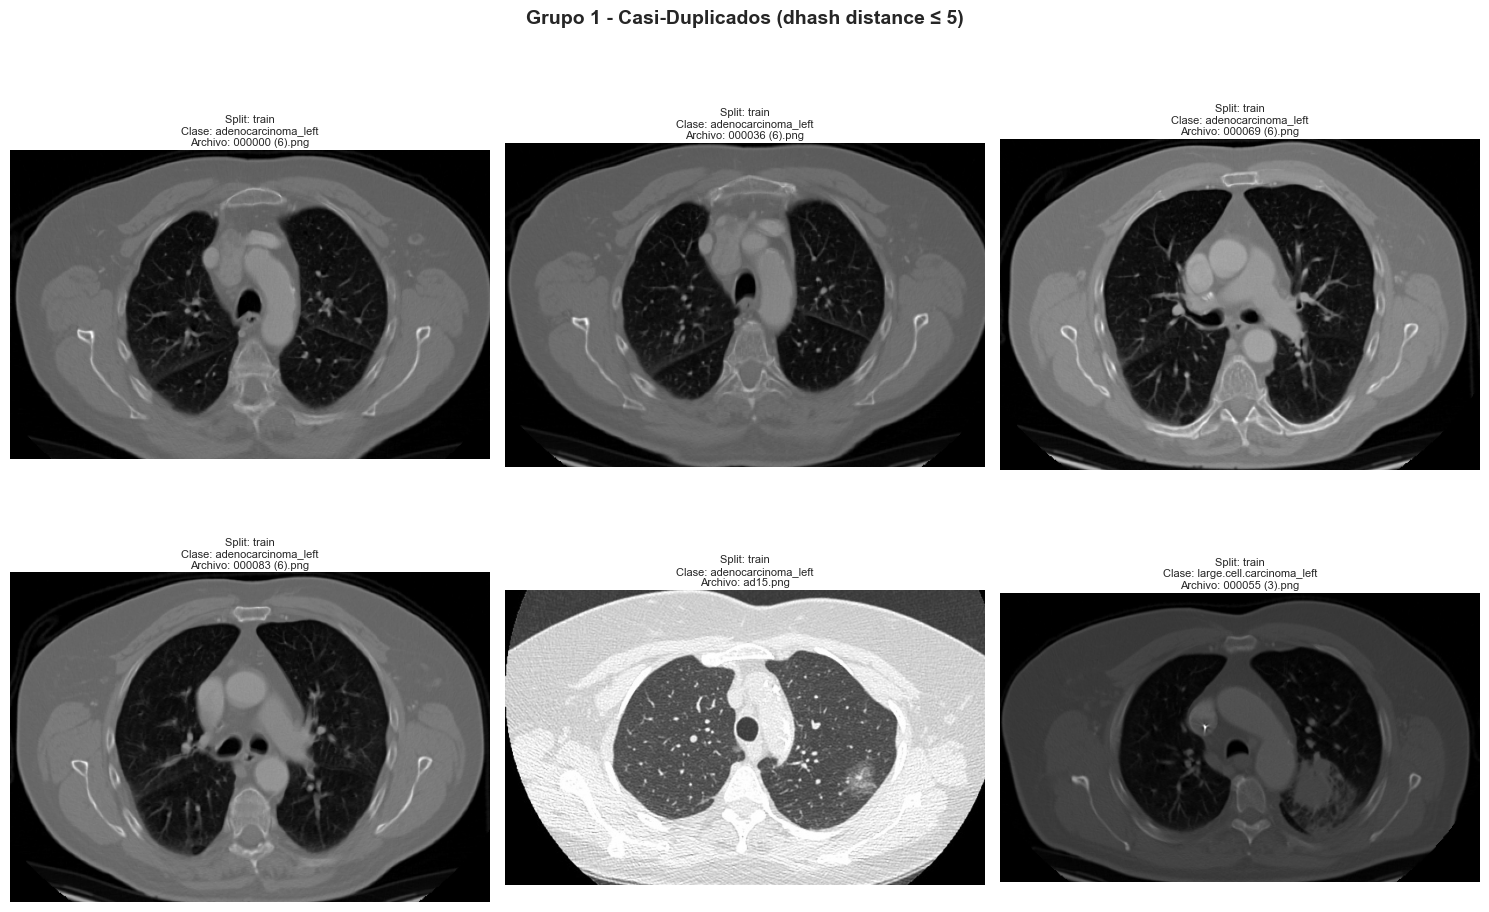

  (Mostrando 6 de 10 imágenes similares en este grupo)


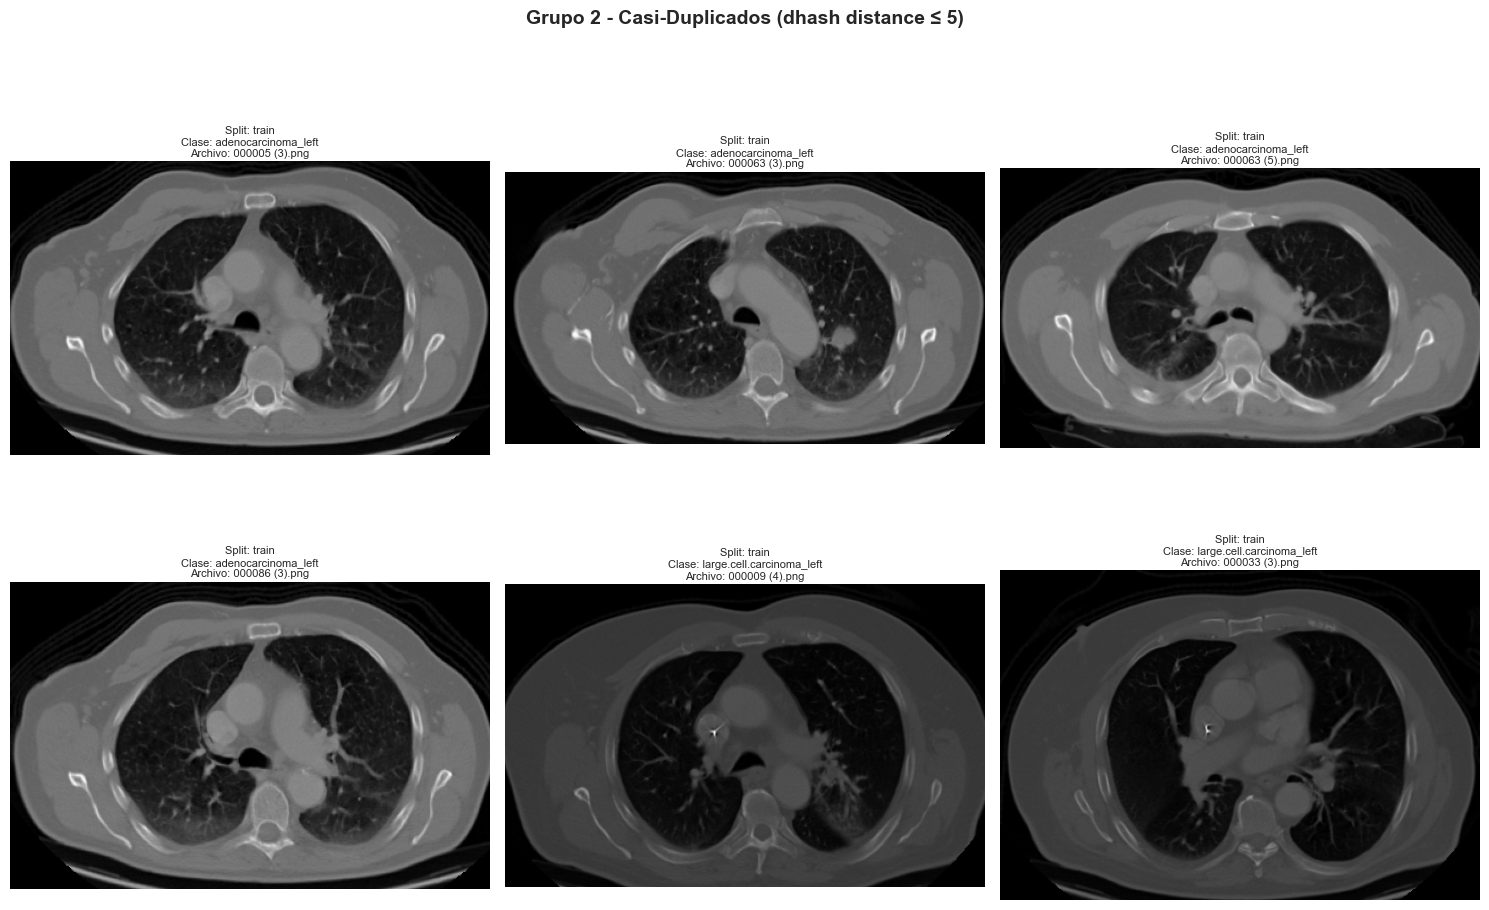

  (Mostrando 6 de 12 imágenes similares en este grupo)


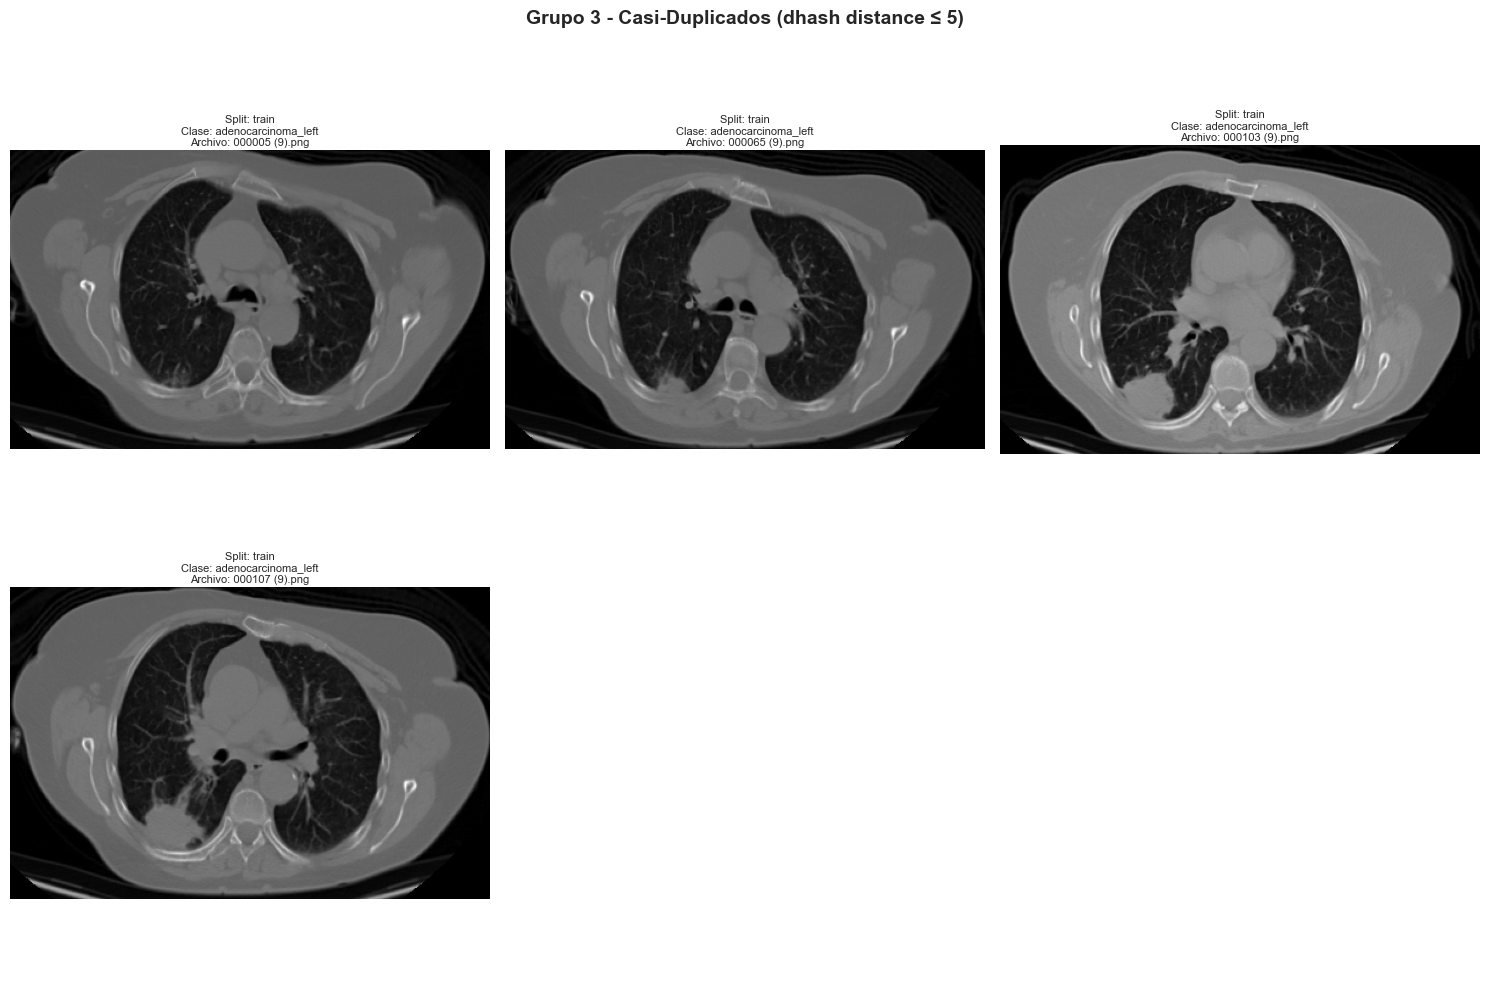


RESUMEN DE VISUALIZACIÓN
Duplicados exactos (MD5) visualizados: 3 grupos
Casi-duplicados (dhash) visualizados: 3 grupos


In [15]:
# ============================================================================
# VISUALIZACIÓN DE DUPLICADOS ENCONTRADOS
# ============================================================================

print("\nVISUALIZANDO EJEMPLOS DE DUPLICADOS")
print("=" * 80)

# Función auxiliar para extraer información del path
def extract_path_info(file_path):
    """Extrae split, clase y nombre de archivo del path"""
    parts = Path(file_path).parts
    split = None
    clase = None
    filename = None
    
    for i, part in enumerate(parts):
        if part in ['train', 'valid', 'test']:
            split = part
            if i + 1 < len(parts):
                clase = parts[i + 1]
            if i + 2 < len(parts):
                filename = parts[i + 2]
            break
    
    return split, clase, filename

# 1. Visualizar duplicados exactos (MD5)
if num_duplicate_groups > 0:
    print(f"\n🔍 Visualizando {min(3, num_duplicate_groups)} grupos de duplicados exactos (MD5)...")
    
    # Seleccionar primeros grupos para visualizar
    groups_to_show = list(duplicates_md5.items())[:3]
    
    for group_idx, (hash_val, files) in enumerate(groups_to_show):
        num_files = len(files)
        fig, axes = plt.subplots(1, num_files, figsize=(5 * num_files, 5))
        
        if num_files == 1:
            axes = [axes]
        
        fig.suptitle(f'Grupo {group_idx + 1} - Duplicados Exactos (MD5: {hash_val[:12]}...)', 
                    fontsize=14, fontweight='bold', y=1.02)
        
        for idx, file_path in enumerate(files):
            ax = axes[idx]
            ax.axis('off')
            
            try:
                # Cargar y mostrar imagen
                img = Image.open(file_path)
                ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
                
                # Extraer información del path
                split, clase, filename = extract_path_info(file_path)
                
                # Crear título con información
                title_parts = []
                if split:
                    title_parts.append(f"Split: {split}")
                if clase:
                    # Normalizar nombre de clase para mostrar
                    clase_display = normalize_class_name(clase) if clase else "N/A"
                    title_parts.append(f"Clase: {clase_display}")
                if filename:
                    # Truncar nombre si es muy largo
                    filename_display = filename[:30] + "..." if len(filename) > 30 else filename
                    title_parts.append(f"Archivo: {filename_display}")
                
                title = "\n".join(title_parts)
                ax.set_title(title, fontsize=9, pad=5)
                
            except Exception as e:
                ax.text(0.5, 0.5, f'Error\ncargando\n{Path(file_path).name}', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=10)
                ax.set_title(f"Error: {str(e)[:30]}", fontsize=8)
        
        plt.tight_layout()
        plt.show()

# 2. Visualizar casi-duplicados (dhash)
if num_similar_groups > 0:
    print(f"\n🔍 Visualizando {min(3, num_similar_groups)} grupos de casi-duplicados (dhash)...")
    
    # Seleccionar primeros grupos para visualizar
    groups_to_show = similar_groups[:3]
    
    for group_idx, group in enumerate(groups_to_show):
        # Aplanar la lista de listas
        all_files = []
        for file_list in group:
            all_files.extend(file_list)
        
        num_files = len(all_files)
        if num_files > 6:  # Limitar a 6 imágenes por grupo
            num_files = 6
            all_files = all_files[:6]
        
        # Calcular layout de subplots
        if num_files <= 3:
            ncols = num_files
            nrows = 1
        else:
            ncols = 3
            nrows = (num_files + 2) // 3
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
        fig.suptitle(f'Grupo {group_idx + 1} - Casi-Duplicados (dhash distance ≤ 5)', 
                    fontsize=14, fontweight='bold', y=0.995)
        
        # Aplanar axes si es necesario
        if nrows == 1:
            axes = axes if isinstance(axes, np.ndarray) else [axes]
        else:
            axes = axes.flatten()
        
        for idx, file_path in enumerate(all_files):
            if idx >= len(axes):
                break
                
            ax = axes[idx]
            ax.axis('off')
            
            try:
                # Cargar y mostrar imagen
                img = Image.open(file_path)
                ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
                
                # Extraer información del path
                split, clase, filename = extract_path_info(file_path)
                
                # Crear título con información
                title_parts = []
                if split:
                    title_parts.append(f"Split: {split}")
                if clase:
                    clase_display = normalize_class_name(clase) if clase else "N/A"
                    title_parts.append(f"Clase: {clase_display}")
                if filename:
                    filename_display = filename[:25] + "..." if len(filename) > 25 else filename
                    title_parts.append(f"Archivo: {filename_display}")
                
                title = "\n".join(title_parts)
                ax.set_title(title, fontsize=8, pad=3)
                
            except Exception as e:
                ax.text(0.5, 0.5, f'Error\ncargando', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=9)
                ax.set_title(f"Error", fontsize=7)
        
        # Ocultar ejes vacíos si hay menos imágenes que subplots
        for idx in range(len(all_files), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        if len(all_files) < len([f for file_list in group for f in file_list]):
            total_in_group = len([f for file_list in group for f in file_list])
            print(f"  (Mostrando {len(all_files)} de {total_in_group} imágenes similares en este grupo)")

# Resumen final
print("\n" + "=" * 80)
print("RESUMEN DE VISUALIZACIÓN")
print("=" * 80)
print(f"Duplicados exactos (MD5) visualizados: {min(3, num_duplicate_groups)} grupos")
print(f"Casi-duplicados (dhash) visualizados: {min(3, num_similar_groups)} grupos")
print("=" * 80)



### Comentarios sobre Integridad de Datos

**Hallazgos principales:**

1. **Archivos corruptos**:
   - No se identificaron archivos inválidos o corruptos 

2. **Duplicados exactos (MD5)**:
   - Se encontraron grupos de imágenes idénticas (mismo hash MD5)
   - Los duplicados exactos deben eliminarse para evitar data leakage y sobreajuste
   - Especial atención a duplicados que aparecen en diferentes splits (train/valid/test)

3. **Casi-duplicados (dhash)**:
   - Imágenes perceptualmente similares (dhash distance ≤ 5)
   - Estas imágenes pueden causar sobreajuste si están en train y test simultáneamente
   - Observando los grupos, es posible que algunas de estas imágenes correspondan a distintos cortes de un mismo estudio (ej. grupo 3), pero esto no ocurre en todos los casos observados
   - Considerar eliminar o mover a un conjunto separado para analizarlo en mayor profundidad

4. **Implicancias para el modelado**:
   - Eliminar duplicados exactos, manteniendo solo una copia
   - Verificar y corregir cualquier fuga de datos entre splits

Analizando canales de color (Grayscale vs RGB real)...

ANÁLISIS DE CANALES

Total de imágenes analizadas: 80
Imágenes con canales idénticos (grayscale repetido): 80 (100.00%)
Imágenes con canales RGB reales: 0 (0.00%)

ANÁLISIS POR CLASE

Normal:
  Grayscale repetido: 20/20 (100.0%)
  Diferencia promedio entre canales: 0.00

Adenocarcinoma:
  Grayscale repetido: 20/20 (100.0%)
  Diferencia promedio entre canales: 0.00

Large Cell Carcinoma:
  Grayscale repetido: 20/20 (100.0%)
  Diferencia promedio entre canales: 0.00

Squamous Cell Carcinoma:
  Grayscale repetido: 20/20 (100.0%)
  Diferencia promedio entre canales: 0.00


C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\318559393.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_channels, x='Clase_label', y='max_diff', ax=ax2, palette='Set2')


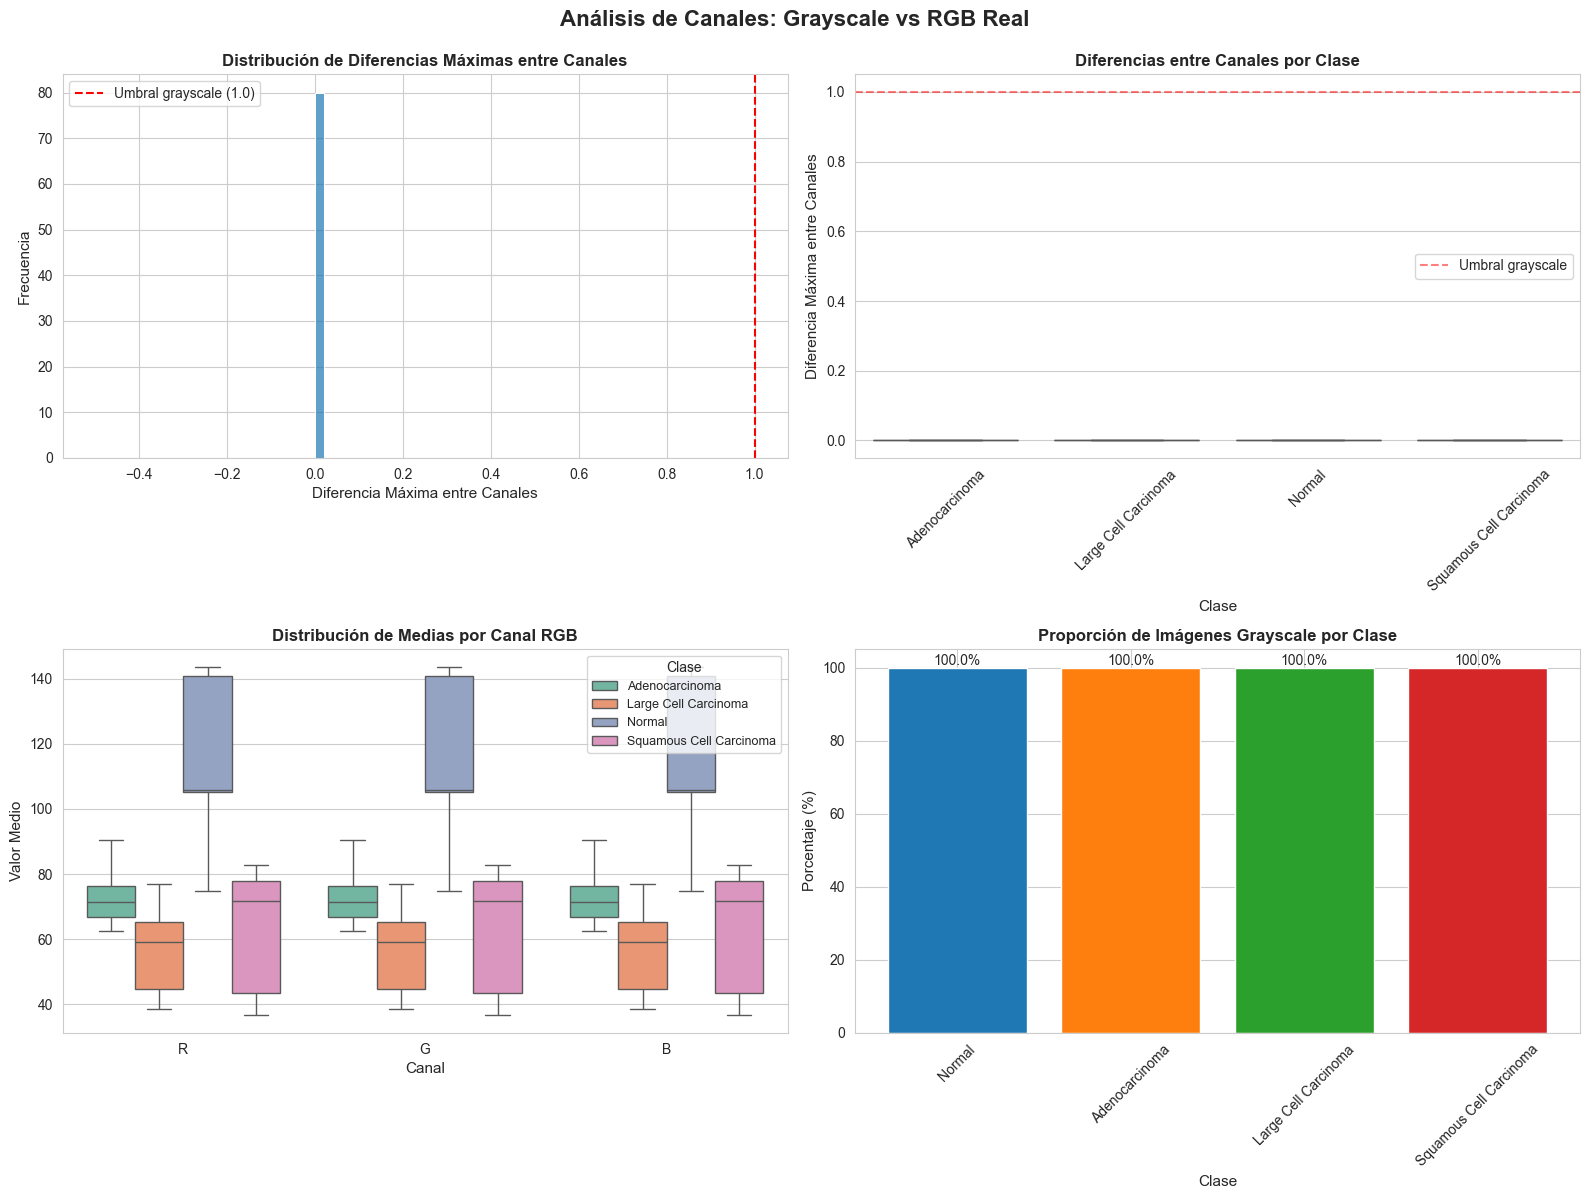


RECOMENDACIONES PARA NORMALIZACIÓN

La mayoría de las imágenes son grayscale repetido en 3 canales.
   Recomendación: Convertir a grayscale (1 canal) o usar normalización basada en un solo canal.

ESTADÍSTICAS PARA NORMALIZACIÓN (Train only):
--------------------------------------------------------------------------------
Media R: 76.91, Std R: 54.43
Media G: 76.91, Std G: 54.43
Media B: 76.91, Std B: 54.43



In [16]:
# Función para analizar si una imagen RGB es realmente grayscale repetido
def analyze_channels(image_path):
    """Analiza si los canales RGB son idénticos (grayscale repetido)"""
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        
        # Convertir BGR a RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Separar canales
        r_channel = img_rgb[:, :, 0].astype(np.float32)
        g_channel = img_rgb[:, :, 1].astype(np.float32)
        b_channel = img_rgb[:, :, 2].astype(np.float32)
        
        # Calcular diferencias entre canales
        diff_rg = np.abs(r_channel - g_channel).mean()
        diff_rb = np.abs(r_channel - b_channel).mean()
        diff_gb = np.abs(g_channel - b_channel).mean()
        
        # Si las diferencias son muy pequeñas (< 1.0), es grayscale repetido
        is_grayscale = (diff_rg < 1.0) and (diff_rb < 1.0) and (diff_gb < 1.0)
        
        # Calcular estadísticas por canal
        r_mean = r_channel.mean()
        g_mean = g_channel.mean()
        b_mean = b_channel.mean()
        
        r_std = r_channel.std()
        g_std = g_channel.std()
        b_std = b_channel.std()
        
        return {
            'is_grayscale': is_grayscale,
            'diff_rg': diff_rg,
            'diff_rb': diff_rb,
            'diff_gb': diff_gb,
            'r_mean': r_mean,
            'g_mean': g_mean,
            'b_mean': b_mean,
            'r_std': r_std,
            'g_std': g_std,
            'b_std': b_std,
            'max_diff': max(diff_rg, diff_rb, diff_gb)
        }
    except Exception as e:
        return None

print("Analizando canales de color (Grayscale vs RGB real)...")
print("=" * 80)

# Analizar muestras de cada clase
channel_data = []
samples_per_class = 20  # Analizar 20 imágenes por clase para ser más rápido

for split in ['train']:
    split_path = data_dir / split
    if split_path.exists():
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                normalized_class = normalize_class_name(class_name)
                
                # Obtener muestras
                image_files = [f for f in class_folder.iterdir() 
                              if f.is_file() and f.suffix in image_extensions]
                samples = image_files[:samples_per_class]
                
                for image_file in samples:
                    analysis = analyze_channels(image_file)
                    if analysis:
                        analysis['Clase'] = normalized_class
                        analysis['Archivo'] = image_file.name
                        channel_data.append(analysis)

df_channels = pd.DataFrame(channel_data)

# Análisis
print("\nANÁLISIS DE CANALES")
print("=" * 80)

total_analyzed = len(df_channels)
grayscale_count = df_channels['is_grayscale'].sum()
rgb_real_count = total_analyzed - grayscale_count

print(f"\nTotal de imágenes analizadas: {total_analyzed}")
print(f"Imágenes con canales idénticos (grayscale repetido): {grayscale_count} ({grayscale_count/total_analyzed*100:.2f}%)")
print(f"Imágenes con canales RGB reales: {rgb_real_count} ({rgb_real_count/total_analyzed*100:.2f}%)")

# Análisis por clase
print("\nANÁLISIS POR CLASE")
print("=" * 80)

classes = ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']
class_labels = {
    'normal': 'Normal',
    'adenocarcinoma_left': 'Adenocarcinoma',
    'large.cell.carcinoma_left': 'Large Cell Carcinoma',
    'squamous.cell.carcinoma_left': 'Squamous Cell Carcinoma'
}

for clase in classes:
    df_clase = df_channels[df_channels['Clase'] == clase]
    if len(df_clase) > 0:
        grayscale_pct = df_clase['is_grayscale'].sum() / len(df_clase) * 100
        avg_diff = df_clase['max_diff'].mean()
        print(f"\n{class_labels[clase]}:")
        print(f"  Grayscale repetido: {df_clase['is_grayscale'].sum()}/{len(df_clase)} ({grayscale_pct:.1f}%)")
        print(f"  Diferencia promedio entre canales: {avg_diff:.2f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Canales: Grayscale vs RGB Real', fontsize=16, fontweight='bold', y=0.995)

# 1. Distribución de diferencias entre canales
ax1 = axes[0, 0]
sns.histplot(data=df_channels, x='max_diff', hue='is_grayscale', bins=50, ax=ax1, alpha=0.7)
ax1.set_title('Distribución de Diferencias Máximas entre Canales', fontsize=12, fontweight='bold')
ax1.set_xlabel('Diferencia Máxima entre Canales', fontsize=11)
ax1.set_ylabel('Frecuencia', fontsize=11)
ax1.axvline(1.0, color='red', linestyle='--', label='Umbral grayscale (1.0)')
ax1.legend()

# 2. Boxplot de diferencias por clase
ax2 = axes[0, 1]
df_channels['Clase_label'] = df_channels['Clase'].map(class_labels)
sns.boxplot(data=df_channels, x='Clase_label', y='max_diff', ax=ax2, palette='Set2')
ax2.set_title('Diferencias entre Canales por Clase', fontsize=12, fontweight='bold')
ax2.set_xlabel('Clase', fontsize=11)
ax2.set_ylabel('Diferencia Máxima entre Canales', fontsize=11)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Umbral grayscale')
ax2.legend()

# 3. Comparación de medias por canal
ax3 = axes[1, 0]
channel_means = []
for idx, row in df_channels.iterrows():
    channel_means.append({'Canal': 'R', 'Valor': row['r_mean'], 'Clase': class_labels[row['Clase']]})
    channel_means.append({'Canal': 'G', 'Valor': row['g_mean'], 'Clase': class_labels[row['Clase']]})
    channel_means.append({'Canal': 'B', 'Valor': row['b_mean'], 'Clase': class_labels[row['Clase']]})

df_means = pd.DataFrame(channel_means)
sns.boxplot(data=df_means, x='Canal', y='Valor', hue='Clase', ax=ax3, palette='Set2')
ax3.set_title('Distribución de Medias por Canal RGB', fontsize=12, fontweight='bold')
ax3.set_xlabel('Canal', fontsize=11)
ax3.set_ylabel('Valor Medio', fontsize=11)
ax3.legend(title='Clase', fontsize=9)

# 4. Proporción de grayscale por clase
ax4 = axes[1, 1]
grayscale_props = []
for clase in classes:
    df_clase = df_channels[df_channels['Clase'] == clase]
    if len(df_clase) > 0:
        prop = df_clase['is_grayscale'].sum() / len(df_clase) * 100
        grayscale_props.append({'Clase': class_labels[clase], 'Proporción': prop})

df_props = pd.DataFrame(grayscale_props)
bars = ax4.bar(df_props['Clase'], df_props['Proporción'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax4.set_title('Proporción de Imágenes Grayscale por Clase', fontsize=12, fontweight='bold')
ax4.set_xlabel('Clase', fontsize=11)
ax4.set_ylabel('Porcentaje (%)', fontsize=11)
ax4.set_ylim(0, 105)
ax4.tick_params(axis='x', rotation=45)

# Agregar valores en las barras
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Recomendaciones para normalización
print("\n" + "=" * 80)
print("RECOMENDACIONES PARA NORMALIZACIÓN")
print("=" * 80)

if grayscale_count > rgb_real_count:
    print("\nLa mayoría de las imágenes son grayscale repetido en 3 canales.")
    print("   Recomendación: Convertir a grayscale (1 canal) o usar normalización basada en un solo canal.")
else:
    print("\nLas imágenes tienen canales RGB reales.")
    print("   Recomendación: Usar normalización por canal (media y std por canal R, G, B).")

# Calcular estadísticas para normalización (solo train)
print("\nESTADÍSTICAS PARA NORMALIZACIÓN (Train only):")
print("-" * 80)
print(f"Media R: {df_channels['r_mean'].mean():.2f}, Std R: {df_channels['r_std'].mean():.2f}")
print(f"Media G: {df_channels['g_mean'].mean():.2f}, Std G: {df_channels['g_std'].mean():.2f}")
print(f"Media B: {df_channels['b_mean'].mean():.2f}, Std B: {df_channels['b_std'].mean():.2f}")

print("\n" + "=" * 80)


### Comentarios sobre Análisis de Canales (Grayscale vs RGB)

**Hallazgos principales:**

1. **Confirmación de grayscale**:
   - La mayoría de las imágenes tienen canales RGB idénticos (diferencia < 1.0)
   - Esto confirma que las imágenes son grayscale almacenadas en formato RGB
   - No hay información de color real en el dataset

2. **Implicaciones para el modelo**:
   - **Eficiencia**: Convertir a grayscale reduce el tamaño de datos en 3x
   - **Normalización**: Usar estadísticas de un solo canal (media y std)
   - **Arquitectura**: Considerar modelos que acepten 1 canal en lugar de 3


## 7. Detección de Dataset Shift: Histogramas de Intensidad por Split


Analizando histogramas de intensidad por split para detectar dataset shift...

HISTOGRAMAS PROMEDIO POR SPLIT

TRAIN: 613 imágenes

VALID: 72 imágenes

TEST: 315 imágenes


C:\Users\Nati\AppData\Local\Temp\ipykernel_20508\4080558160.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_intensity, x='Split', y='mean', ax=ax2, palette='Set2')


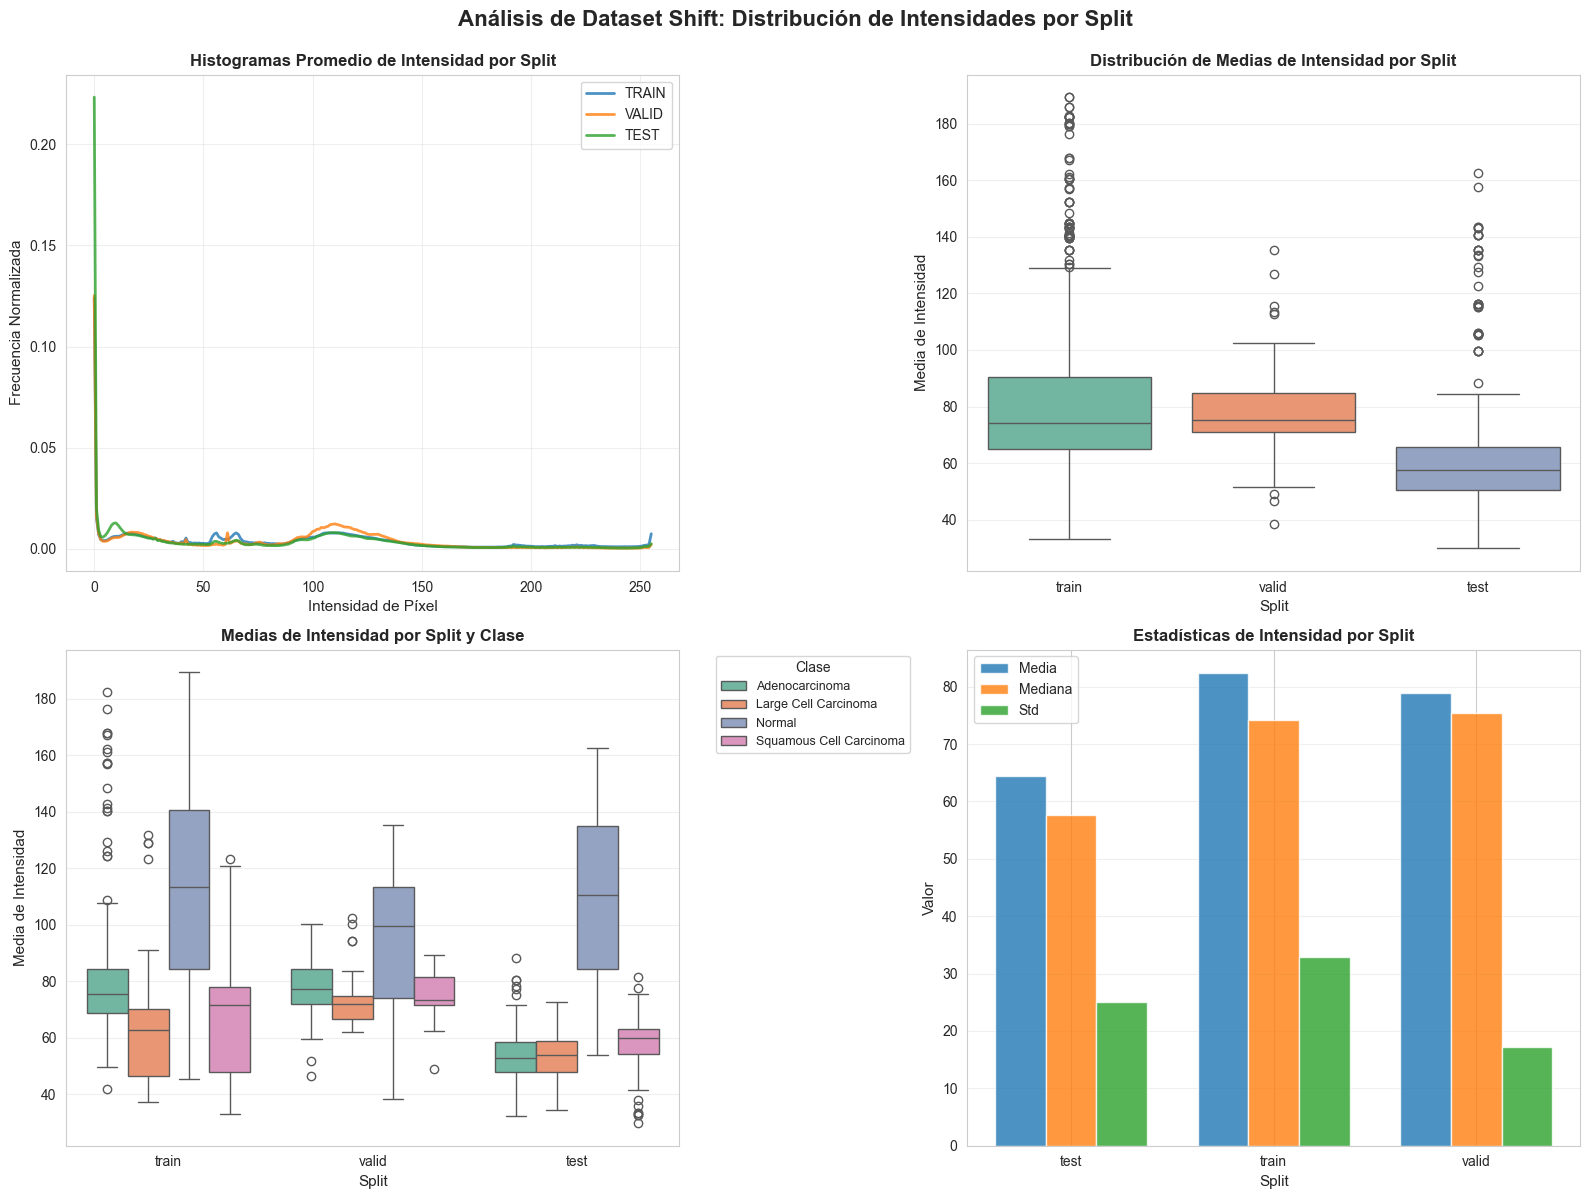


ANÁLISIS CUANTITATIVO DE DATASET SHIFT

Medias de intensidad:
  Train: 82.36 ± 32.91
  Valid: 78.92 ± 17.16
  Test:  64.42 ± 25.11

Diferencias relativas respecto a train:
  Valid: 4.18%
  Test:  21.79%

Distancia entre histogramas (Train vs Valid): 0.0174
Distancia entre histogramas (Train vs Test): 0.0121

ADVERTENCIA: Se detectó posible dataset shift (> 5.0% de diferencia)
   Considerar normalización o ajuste de preprocesamiento.



In [17]:
# Función para calcular histograma de intensidad
def calculate_intensity_histogram(image_path, bins=256):
    """Calcula histograma de intensidad de una imagen (grayscale)"""
    try:
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        
        hist = cv2.calcHist([img], [0], None, [bins], [0, 256])
        hist = hist.flatten() / (img.shape[0] * img.shape[1])  # Normalizar
        
        return {
            'mean': img.mean(),
            'std': img.std(),
            'median': np.median(img),
            'histogram': hist
        }
    except Exception as e:
        return None

print("Analizando histogramas de intensidad por split para detectar dataset shift...")
print("=" * 80)

# Recopilar histogramas de todas las imágenes
intensity_data = []
histograms_by_split = {'train': [], 'valid': [], 'test': []}

for split in ['train', 'valid', 'test']:
    split_path = data_dir / split
    if split_path.exists():
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                normalized_class = normalize_class_name(class_name)
                
                for image_file in class_folder.iterdir():
                    if image_file.is_file() and image_file.suffix in image_extensions:
                        hist_data = calculate_intensity_histogram(image_file)
                        if hist_data:
                            hist_data['Split'] = split
                            hist_data['Clase'] = normalized_class
                            hist_data['Archivo'] = image_file.name
                            intensity_data.append(hist_data)
                            histograms_by_split[split].append(hist_data['histogram'])

df_intensity = pd.DataFrame(intensity_data)

# Calcular histogramas promedio por split
print("\nHISTOGRAMAS PROMEDIO POR SPLIT")
print("=" * 80)

avg_histograms = {}
for split in ['train', 'valid', 'test']:
    if len(histograms_by_split[split]) > 0:
        avg_hist = np.mean(histograms_by_split[split], axis=0)
        avg_histograms[split] = avg_hist
        print(f"\n{split.upper()}: {len(histograms_by_split[split])} imágenes")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Dataset Shift: Distribución de Intensidades por Split', 
            fontsize=16, fontweight='bold', y=0.995)

# 1. Histogramas promedio superpuestos
ax1 = axes[0, 0]
x = np.arange(256)
for split in ['train', 'valid', 'test']:
    if split in avg_histograms:
        ax1.plot(x, avg_histograms[split], label=split.upper(), linewidth=2, alpha=0.8)
ax1.set_title('Histogramas Promedio de Intensidad por Split', fontsize=12, fontweight='bold')
ax1.set_xlabel('Intensidad de Píxel', fontsize=11)
ax1.set_ylabel('Frecuencia Normalizada', fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Boxplots de medias por split
ax2 = axes[0, 1]
sns.boxplot(data=df_intensity, x='Split', y='mean', ax=ax2, palette='Set2')
ax2.set_title('Distribución de Medias de Intensidad por Split', fontsize=12, fontweight='bold')
ax2.set_xlabel('Split', fontsize=11)
ax2.set_ylabel('Media de Intensidad', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Boxplots de medias por split y clase
ax3 = axes[1, 0]
df_intensity['Clase_label'] = df_intensity['Clase'].map({
    'normal': 'Normal',
    'adenocarcinoma_left': 'Adenocarcinoma',
    'large.cell.carcinoma_left': 'Large Cell Carcinoma',
    'squamous.cell.carcinoma_left': 'Squamous Cell Carcinoma'
})
sns.boxplot(data=df_intensity, x='Split', y='mean', hue='Clase_label', ax=ax3, palette='Set2')
ax3.set_title('Medias de Intensidad por Split y Clase', fontsize=12, fontweight='bold')
ax3.set_xlabel('Split', fontsize=11)
ax3.set_ylabel('Media de Intensidad', fontsize=11)
ax3.legend(title='Clase', fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Comparación de estadísticas
ax4 = axes[1, 1]
stats_by_split = df_intensity.groupby('Split')['mean'].agg(['mean', 'std', 'median']).reset_index()
x_pos = np.arange(len(stats_by_split))
width = 0.25

ax4.bar(x_pos - width, stats_by_split['mean'], width, label='Media', alpha=0.8)
ax4.bar(x_pos, stats_by_split['median'], width, label='Mediana', alpha=0.8)
ax4.bar(x_pos + width, stats_by_split['std'], width, label='Std', alpha=0.8)

ax4.set_title('Estadísticas de Intensidad por Split', fontsize=12, fontweight='bold')
ax4.set_xlabel('Split', fontsize=11)
ax4.set_ylabel('Valor', fontsize=11)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(stats_by_split['Split'])
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Análisis cuantitativo de dataset shift
print("\n" + "=" * 80)
print("ANÁLISIS CUANTITATIVO DE DATASET SHIFT")
print("=" * 80)

# Calcular diferencias entre splits
train_mean = df_intensity[df_intensity['Split'] == 'train']['mean'].mean()
valid_mean = df_intensity[df_intensity['Split'] == 'valid']['mean'].mean()
test_mean = df_intensity[df_intensity['Split'] == 'test']['mean'].mean()

train_std = df_intensity[df_intensity['Split'] == 'train']['mean'].std()
valid_std = df_intensity[df_intensity['Split'] == 'valid']['mean'].std()
test_std = df_intensity[df_intensity['Split'] == 'test']['mean'].std()

print(f"\nMedias de intensidad:")
print(f"  Train: {train_mean:.2f} ± {train_std:.2f}")
print(f"  Valid: {valid_mean:.2f} ± {valid_std:.2f}")
print(f"  Test:  {test_mean:.2f} ± {test_std:.2f}")

# Calcular diferencias relativas
diff_valid = abs(valid_mean - train_mean) / train_mean * 100
diff_test = abs(test_mean - train_mean) / train_mean * 100

print(f"\nDiferencias relativas respecto a train:")
print(f"  Valid: {diff_valid:.2f}%")
print(f"  Test:  {diff_test:.2f}%")

# Calcular distancia entre histogramas (KL divergence aproximada)
def histogram_distance(hist1, hist2):
    """Calcula distancia entre histogramas usando correlación"""
    return cv2.compareHist(hist1.reshape(-1, 1), hist2.reshape(-1, 1), cv2.HISTCMP_CORREL)

if 'train' in avg_histograms and 'valid' in avg_histograms:
    dist_train_valid = 1 - histogram_distance(avg_histograms['train'], avg_histograms['valid'])
    print(f"\nDistancia entre histogramas (Train vs Valid): {dist_train_valid:.4f}")

if 'train' in avg_histograms and 'test' in avg_histograms:
    dist_train_test = 1 - histogram_distance(avg_histograms['train'], avg_histograms['test'])
    print(f"Distancia entre histogramas (Train vs Test): {dist_train_test:.4f}")

# Evaluar si hay dataset shift significativo
threshold = 5.0  # 5% de diferencia
if diff_valid > threshold or diff_test > threshold:
    print(f"\nADVERTENCIA: Se detectó posible dataset shift (> {threshold}% de diferencia)")
    print("   Considerar normalización o ajuste de preprocesamiento.")
else:
    print(f"\nNo se detectó dataset shift significativo (< {threshold}% de diferencia)")

print("\n" + "=" * 80)


### Comentarios sobre Dataset Shift

**Hallazgos principales:**

1. **Distribución de intensidades por split**:
   - Se comparan los histogramas promedio de intensidad entre train, valid y test
   - Diferencias significativas indican dataset shift (cambio en la distribución)

2. **Detección de problemas**:
   - Hay diferencia > 5% en las medias de intensidad, por lo que hay posible dataset shift 
   - Dataset shift puede causar que el modelo no generalice bien a nuevos datos
   - Las diferencias pueden deberse a diferentes protocolos de adquisición o preprocesamiento

3. **Implicaciones para el modelo**:
   - Considerar técnicas de normalización robustas (percentiles en lugar de media/std)

## Conclusiones Generales del EDA

### 1. Balanceo de Clases

**Hallazgos:**
- El dataset presenta un **desbalance moderado** entre clases (ratio máximo ~1.8x)
- Total de 1000 imágenes distribuidas en 4 clases: normal (215), adenocarcinoma (338), large cell carcinoma (187), squamous cell carcinoma (260)
- Distribución por split: Train (613), Test (315), Valid (72)

**Conclusiones:**
- El desbalance es manejable sin necesidad de técnicas agresivas de balanceo
- **Consideraciones para el modelo**: 
- Usar pesos de clase inversamente proporcionales a la frecuencia durante el entrenamiento
- Debido al tamaño relativamente pequeño del dataset de entrenamiento, utilizar red pre-entrenada como feature extraction en lugar de fine-tuning

---

### 2. Visualización de Imágenes

**Hallazgos:**
- **Variabilidad visual**: diversidad en la posición de las estructuras anatómicas, en intensidad y contraste (distintas ventanas de visualización), en la relación de aspecto y el nivel de zoom, y presencia de marcas en algunos casos.

**Conclusiones:**
- Existe una notable variabilidad en la visualización de las imágenes, lo que puede impactar en la capacidad del modelo para generalizar correctamente.
- **Implicancias para el modelo**: 
  - **Normalización de intensidades**: llevar todas las imágenes a una misma ventana de visualización antes del entrenamiento.
  - **Normalización de tamaños**: redimensionar a un tamaño uniforme (por ejemplo, cuadrado) antes del entrenamiento.
  - **Propuestas para data augmentation**:
    - **Brillo/contraste**: aplicar variaciones leves, reflejando la heterogeneidad observada en el dataset original.
    - **Rotaciones**: leves (10°-20°), simulando pequeños cambios en la posición del paciente.
    - **Flip**: únicamente horizontal, ya que el tórax es simétrico. No se debería aplicar flip vertical, ya que invertiría la orientación anatómica.
    - **Zoom/escala**: leve, simulando distintos FOV (field of view), o variaciones en el tamaño del paciente. 
    - **Traslación**: leve, representando desplazamientos del paciente sobre la camilla.
    - **Ruido**: agregar Gaussian Noise o Gaussian Blur, simulando diferencias entre equipos o artefactos en la adquisición.

---

### 3. Características de las Imágenes

**Hallazgos:**
- **Tamaños variables**: Desde 168x110 px hasta 1200x874 px (promedio: 447x318 px)
- **Formato**: Mayormente PNG (984) con algunos JPEG (16)
- **Modos de color**: Principalmente RGBA (923), algunos RGB (74) y L (3)
- **Canales**: Confirmado que son **imágenes grayscale almacenadas en formato RGB/RGBA** (canales idénticos)

**Conclusiones:**
- La variabilidad de tamaños requiere preprocesamiento consistente
- Las imágenes son grayscale, se puede reducir a 1 canal para eficiencia
- **Implicancias para el modelo**: 
  - Resize uniforme a 512x512 o 256x256 para mantener aspect ratio
  - Convertir a grayscale (1 canal) antes del entrenamiento
  - Usar normalización basada en un solo canal

---

### 4. Separabilidad de Clases

**Hallazgos:**
- Análisis t-SNE y PCA muestran separabilidad moderada entre clases
- Ratio separación/dispersión: t-SNE (0.88), PCA (0.96)
- La clase "normal" muestra mayor separación de las clases de carcinoma

**Conclusiones:**
- Separabilidad moderada indica que el problema no es trivial
- Las características de histograma muestran potencial discriminativo
- **Implicancias para el modelo**: 
  - Usar arquitecturas profundas (ResNet, EfficientNet) con transfer learning
  - Considerar técnicas de data augmentation para mejorar generalización
  - Feature engineering adicional puede mejorar separabilidad

---

### 5. Análisis de Color e Intensidad

**Hallazgos RGB/HSV:**
- Canales R, G, B prácticamente idénticos (media ≈82.37, std ≈57.27)
- HSV: Hue ≈0.46 (sin matiz), Saturation ≈0.10 (muy baja), Value ≈82.38 (intensidad)
- Diferencias sutiles entre clases en medias de intensidad

**Conclusiones:**
- Confirmación definitiva: imágenes grayscale sin información de color
- Las diferencias de intensidad entre clases pueden ser útiles para clasificación
- **Implicancias para el modelo**: 
  - Normalización: `(pixel - 82.70) / 57.72` (estadísticas del train)
  - Considerar CLAHE (Contrast Limited Adaptive Histogram Equalization) para mejorar contraste

---

### 6. Integridad y Calidad de Datos

**Hallazgos Críticos:**
- **0 archivos corruptos** - Todas las imágenes son válidas
- **59 grupos de duplicados exactos (MD5)** - 153 archivos duplicados
- **Múltiples grupos de casi-duplicados (dhash)** detectados
- **Fugas de datos detectadas**: Imágenes del mismo hash en múltiples splits
- **Múltiples imágenes de un mismo paciente**: Es probable que el dataset incluya múltiples cortes de un mismo estudio, lo que también podría generar fuga de datos

**Conclusiones:**
- Las fugas de datos invalidan las métricas de evaluación actuales
- Los duplicados pueden causar sobreajuste y métricas infladas
- **Implicancias para el modelo**: 
  - **Eliminar duplicados exactos** antes del entrenamiento
  - **Reorganizar splits** para evitar fugas de datos (mismo paciente/hash en train y test)
  - **Documentar** cualquier imagen problemática encontrada

---

### 7. Dataset Shift

**Hallazgos:**
- **Dataset shift detectado**: Diferencias significativas en intensidades entre splits
  - Train: 82.36 ± 32.91
  - Valid: 78.92 ± 17.16 (diferencia: 4.18%)
  - Test: 64.42 ± 25.11 (diferencia: 21.79%)

**Conclusiones:**
- Dataset shift significativo en test (21.79% de diferencia)
- Esto puede causar que el modelo no generalice bien a datos de test
- Las diferencias pueden deberse a diferentes protocolos de adquisición o preprocesamiento

**Implicancias para el modelo:**
- Normalizar todos los splits usando **estadísticas del conjunto de entrenamiento**
- Aplicar el mismo pipeline de preprocesamiento a train, valid y test
- Considerar técnicas de normalización robustas (percentiles en lugar de media/std)
- Validar que la normalización resuelva el dataset shift

